# Week 2 Assignment - Ames Housing Data, Linear Regression

This week, we build upon last week's initial EDA and perform more extensive EDA and eventually create linear regression models and test them using a Cross-Validatio approach.  Based upon cross-validation results, the 'best' model is used to predict Ames, Iowa housing prices using the test.csv housing data from Kaggle.com.

## Assignment Requirements

The specific requirements for this week's assignment, as well as how these requirements were satisfied, are as follows:

**1. Conduct your analysis using a cross-validation design.** The original train.csv data was split into a training set and a validatin set and cross-validation was used to select between two models that were generated using the training data.

**2. Conduct EDA and provide appropriate visualizations in the process.**  The EDA for this work is shown in the designated EDA section of this notebook. 

**3. Build a minimum of two separate regression models using the training set.** These are discussed in the MODELING section of this notebook.  As discussed above, a Cross-Validation approach was used to select between the two models for use in testing the Kaggle.com test.csv dataset.

**4.  Evaluate polynomial, indicator, dichotomous, & piecewise model components.**  

As discussed in the CONTINUOUS VARIABLES section of this notebook, a 'TotArea' variable was created by summing the original 'GrLivArea' and 'TotBsmtSF' variables, and using this variable, a quadratic term ('TotArea2') and a piecewise model approach were evaluated. (The quadratic term approach was deemed to be a simpler way to address the slight curvature in a scatterplot with the response variable.)

As discussed in the NON-ORDINAL, CATEGORICAL VARIABLES section of this notebook, the number of different categories in the 'Neighborhood' variable was reduced using a k-means clustering approach to group neighborhoods with similar log(SalePrice) statistics, and indicator variables were used to represent the different clusters.

As discussed in the DICHOTOMOUS/BINARY VARIABLES section of this notebook, the 'CentralAir' variable was converted to 0/1 binary and was included in the models.

**5.  Create at least one feature from the data set.**  Several square footage-related variables were created and assessed.  As described above, one of them, 'TotArea', as well as its quadratic version, 'TotArea2', were included in the final models.  The Year sold and Month sold variables were combined to be a single (decimal-valued) Year variable, although this variable did not get selected for use in the models. 

**6.  Evaluate the models’ assumptions.**  Key model assumptions for linear regression are:

*   The relationship between the dependent variable and independent variables is linear -- in this assignment, a linear regression model was created (i.e., predictions for log(SalePrice) could be made using a linear combination of variables).
*   The variables are normally distributed -- in this effort, the primary focus was upon the response variable ('SalePrice'), which was skewed in the original data.  A log(SalePrice) transformation was used to make the distribution significantly more 'Normal'.
*   There is constant variance (homoscedasicity) in the model -- Again, log transformation of the 'SalePrice' response variable improved uniformity in the  variance of the response variable.
*   There is little or no multicollinearity between independent variables -- As discussed during EDA, given certain variables had already been selected for further evaluation (based upon their correlation results with the response variable), other high-response-variable-correlation variables were not considered further if they possessed relatively high correlations with variables that had already been selected. 
*   There is no autocorrelation within the dependent variable observations -- this assumption is hard to prove, but it was generally assumed that the different house 'SalePrice' samples were obtained independently.

**7.  Evaluate goodness of fit metrics on the training and validation sets.**  As discussed in the MODELING section of this notebook, one model exhibited R2=0.854 (training dataset) and R2=0.846 (validation dataset), and the other model exhibited R2=0.860 (training dataset) and R2=0.851 (validation dataset). Since the second model possessed slightly higher R2 values, it was selected for the the Kaggle.com test.csv data test.  

**8.  Submit predictions for the unseen test set available on Kaggle.com.**  This was performed.  Results are shown at the end of this notebook.   

**9. Provide your Kaggle user name and a screen snapshot of your Kaggle scores.**   As shown at the end of this notebook, my Kaggle User Name is "**Joe Bloe**" and my score was **0.16441**.

**10.  Discuss what your models tell you in layman’s terms.**  As discussed at the end of this notebook in the Assignment Summary, the predictors selected for the model were not surprising.  'Neighborhood' addresses the "Location, Location, Location" aspect commonly associated with real estate valuation, 'TotArea' corresponds with the size of the house, 'YearBuilt' corresponds with the "newness" of the house, and 'OverallCond' corresponds with the general condition of the house.  The dichotomous, (Y/N) variable 'CentralAir' was largely included in the model so that there would be a dichotomous variable; however, houses that lack Central Air Conditioning tended to be associated with lower-priced houses, and so it also possessed predictive characteristics.

# INGRESS

In [ ]:
# import libraries
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import statsmodels.api as sm
import math
from sklearn.model_selection import train_test_split
from pylab import hist, show, xticks
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy import optimize
from scipy import interpolate
from numpy.linalg import lstsq
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# get training data
from google.colab import files
upload = files.upload()

Saving train.csv to train.csv


In [ ]:
origTrainDF = pd.read_csv('train.csv')

In [ ]:
# initial inspection of data
pd.set_option('display.max_columns', None)  # display all the columns
origTrainDF.head(10) 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

# EDA

**Overall Approach and Types of Data**

In the Ames Housing dataset, there are approximately 80 different variables, and the variables represent different types of variables.  The main response variable, 'SalePrice,' as well as other, large-magnitude, numeric predictor variables, are considered to be continuous, numeric variables (excluding the fundamental, discrete units of measurement, such as dollars, square feet, etc.). Other low-magnitude numeric variables, such the number of bedrooms, the garage size (number of cars), etc., are intervallic, numeric variables.  Some variables, such as quality ranking variables (ranked numerically or using text descriptors), are not specifically intervallic, but possess ordinal (i.e., low to high) characteristics.  Other categorical variables, such as the Neighborhood where a house resides, do not inherently possess low-to-high rankings or numerical values, but could possibly be assigned these types of values if correlated with variables (e.g., 'SalePrice') that possess these characteristics. Finally, some variables (e.g., the presence of central air conditioning) are dichotomous/binary (i.e., Yes/No or 0/1).

When non-numeric, categorical variables are used in linear regression models, they are typically represented using indicator variables to represent the different categories in the variable.  Unfortunately, if a categorical variable possesses many different categories, this can require multiple indicator variables in the model which can make the model somewhat "messy."  Therefore, if possible, it can be useful to find similarities among different categories, group the similar categories, and thereby reduce the number of different categories in the variable, and hence, the number of different indicator variables required in the model.  In this analysis, a k-means approach was used to group different categories according to statistics associated with the response variable, and thereby, reduce the number of indicator variables for these categorical variables.

With respect to the overall approach in this analysis, the different variables were separated according to their variable type (Continuous, Discrete/Intervallic, Ordinal, Dichotomous/Binary, or Categorical), and the variables in each group were evaluated and selected for possible inclusion in the eventual regression model.

**General inspection of data**

In [ ]:
# get general information
origTrainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
# number of (rows, columns) in the dataframe
origTrainDF.shape

(1460, 81)

**Inspect for Missing Values**

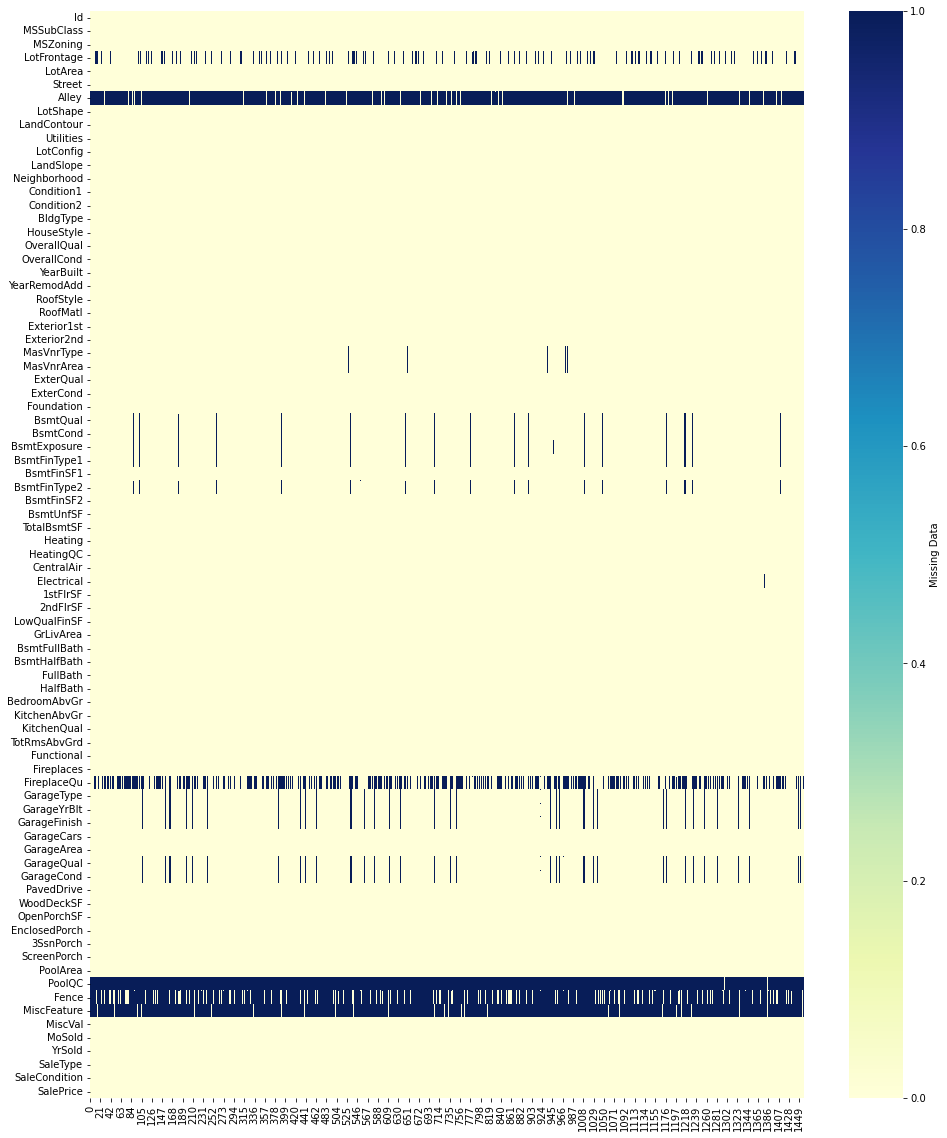

In [ ]:
# missing values of each column (of each variable)-- visualization
plt.figure(figsize=(16,20))
sns.heatmap(origTrainDF.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [ ]:
# missing values for each variable -- listed
pd.set_option('display.max_rows', None)  # display all the results
origTrainDF.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

The visualization and direct listing of missing values in each variable show that the following variables have significant numbers of missing values: LotFrontage, Alley, FireplaceQu, PoolQC, Fence and MiscFeature. Even with its missing values, LotFrontage still has approximately 80% actual values, so it will be retained in the dataset.  However, the other extreme missing value variables will be removed from the dataset.

In [ ]:
# eliminate the variables with significant numbers of missing values
origTrainDF = origTrainDF.drop(columns = ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature'])

origTrainDF.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


In [ ]:
# basic descriptive statistics of all the numerical variables
origTrainDF.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Modify and Create New Features

*Response variable 'SalePrice'*

As shown immediately above, 'SalePrice' possesses 1460 values (the number of rows in the dataset), so there does not appear to be missing values in 'SalePrice' (although this does not ensure all values are valid or possibly outiliers).

The basic statistics and distribution of 'SalePrice' are shown below.

In [ ]:
# descriptive statistics of the dependent variable 'SalePrice'
origTrainDF.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In last week's assignment, the distribution of 'SalePrice' exhibiteed skewness towards the higher end values (as seen in boxplot and histogram).  This skewess can be addressed using a log(SalePrice) transformation.

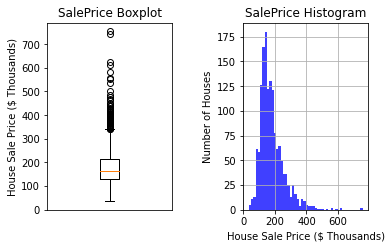

In [ ]:
# initial visualizations of 'SalePrice' data (box plot and histogram)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout(pad=4.0)

# boxplot
ax1.boxplot(origTrainDF.SalePrice/1000)
ax1.set_ylabel('House Sale Price ($ Thousands)')
ax1.set_xticks([])
ax1.set_title('SalePrice Boxplot')

# histogram
ax2.hist(origTrainDF.SalePrice/1000, bins=50, facecolor='blue', alpha=0.75)
ax2.set_ylabel('Number of Houses')
ax2.set_xlabel('House Sale Price ($ Thousands)')
ax2.set_title('SalePrice Histogram')
ax2.grid(True)

plt.show()

In [ ]:
# create new response variable 'logSalePrice'
origTrainDF['logSalePrice'] = np.log(origTrainDF['SalePrice'])

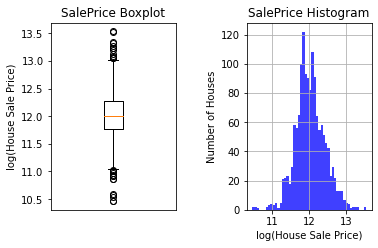

In [ ]:
# visualizations of log-transformed 'SalePrice' data (box plot and histogram)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout(pad=4.0)

# boxplot
ax1.boxplot(origTrainDF.logSalePrice)
ax1.set_ylabel('log(House Sale Price)')
ax1.set_xticks([])
ax1.set_title('SalePrice Boxplot')

# histogram
ax2.hist(origTrainDF.logSalePrice, bins=50, facecolor='blue', alpha=0.75)
ax2.set_ylabel('Number of Houses')
ax2.set_xlabel('log(House Sale Price)')
ax2.set_title('SalePrice Histogram')
ax2.grid(True)

plt.show()

*Square Footage Variables*

Fellow students have suggested that combining square footage variables can create a better combined, square footage, predictor variable.

In [ ]:
origTrainDF['TotalSF'] = origTrainDF['1stFlrSF'] + origTrainDF['2ndFlrSF'] + origTrainDF['BsmtFinSF1'] + origTrainDF['BsmtFinSF2']
origTrainDF['TotLivSF'] = origTrainDF['GrLivArea'] + origTrainDF['BsmtFinSF1'] + origTrainDF['BsmtFinSF2']
origTrainDF['TotArea'] = origTrainDF['GrLivArea'] + origTrainDF['TotalBsmtSF']

*Combine Year and Month dates into one variable*

In [ ]:
# combine month sold with year sold (i.e., decimal number)
origTrainDF['YearMoSold'] = origTrainDF.YrSold + origTrainDF.MoSold/12
origTrainDF = origTrainDF.drop(columns = ['YrSold','MoSold'])

In [ ]:
# check latest variables in dataframe
origTrainDF.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SaleType,SaleCondition,SalePrice,logSalePrice,TotalSF,TotLivSF,TotArea,YearMoSold
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,WD,Normal,208500,12.247694,2416,2416,2566,2008.166667
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,WD,Normal,181500,12.109011,2240,2240,2524,2007.416667
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,WD,Normal,223500,12.317167,2272,2272,2706,2008.750000
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,WD,Abnorml,140000,11.849398,1933,1933,2473,2006.166667
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,WD,Normal,250000,12.429216,2853,2853,3343,2009.000000


-----------------------------------

*Split the original Kaggle.com training dataset into train and validation subsets*

In [ ]:
# split initial training data 80(train):20(validation) using threshold T
T = 0.8 # specified threshold value
desiredRatio = T/(1-T)

trainDF, valDF = train_test_split(origTrainDF, train_size=T)

# count the number of samples in the split training and validation sets
nRowsTrain = trainDF.shape[0]
nColsTrain = trainDF.shape[1]
nRowsVal = valDF.shape[0]
nColsVal = valDF.shape[1]
actualRatio = nRowsTrain/nRowsVal

print('The new training subset has', nRowsTrain, 'rows and', nColsTrain, 'columns.')
print('The validation set has', nRowsVal, 'rows and', nColsVal, 'columns.')
print('\nThe desired size ratio of training:validation datasets is', desiredRatio)
print('The actual size ratio of training:validation datasets is', actualRatio)

The new training subset has 1168 rows and 79 columns.
The validation set has 292 rows and 79 columns.

The desired size ratio of training:validation datasets is 4.000000000000001
The actual size ratio of training:validation datasets is 4.0


In [ ]:
trainDF = trainDF.sort_values(by=['Id'], ascending=True)
trainDF.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SaleType,SaleCondition,SalePrice,logSalePrice,TotalSF,TotLivSF,TotArea,YearMoSold
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,WD,Normal,208500,12.247694,2416,2416,2566,2008.166667
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,WD,Normal,181500,12.109011,2240,2240,2524,2007.416667
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,WD,Abnorml,140000,11.849398,1933,1933,2473,2006.166667
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,WD,Normal,250000,12.429216,2853,2853,3343,2009.000000
5,6,50,RL,85.0,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,700,WD,Normal,143000,11.870600,2094,2094,2158,2009.833333


In [ ]:
valDF = valDF.sort_values(by=['Id'], ascending=True)
valDF.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SaleType,SaleCondition,SalePrice,logSalePrice,TotalSF,TotLivSF,TotArea,YearMoSold
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,WD,Normal,223500,12.317167,2272,2272,2706,2008.750000
6,7,20,RL,75.0,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,0,WD,Normal,307000,12.634603,3063,3063,3380,2007.666667
9,10,190,RL,50.0,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,Attchd,1939.0,RFn,1,205,Gd,TA,Y,0,4,0,0,0,0,0,WD,Normal,118000,11.678440,1928,1928,2068,2008.083333
14,15,20,RL,NaN,10920,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,MetalSd,MetalSd,BrkFace,212.0,TA,TA,CBlock,TA,TA,No,BLQ,733,Unf,0,520,1253,GasA,TA,Y,SBrkr,1253,0,0,1253,1,0,1,1,2,1,TA,5,Typ,1,Attchd,1960.0,RFn,1,352,TA,TA,Y,0,213,176,0,0,0,0,WD,Normal,157000,11.964001,1986,1986,2506,2008.416667
17,18,90,RL,72.0,10791,Pave,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1967,1967,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,Y,SBrkr,1296,0,0,1296,0,0,2,0,2,2,TA,6,Typ,0,CarPort,1967.0,Unf,2,516,TA,TA,Y,0,0,0,0,0,0,500,WD,Normal,90000,11.407565,1296,1296,1296,2006.833333


### CONTINUOUS VARIABLES

In [ ]:
# create dataframe with the continuous variables
#  note that LotFrontage has missing values
continuousDF = trainDF[['SalePrice','logSalePrice','TotalSF','TotLivSF','TotArea',
                        'LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
                        'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
                        'GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
                        '3SsnPorch','ScreenPorch','PoolArea','MiscVal']].copy()

In [ ]:
# impute missing values (e.g., 'LotFrontage') with median value
continuousDF = continuousDF.fillna(continuousDF.median())

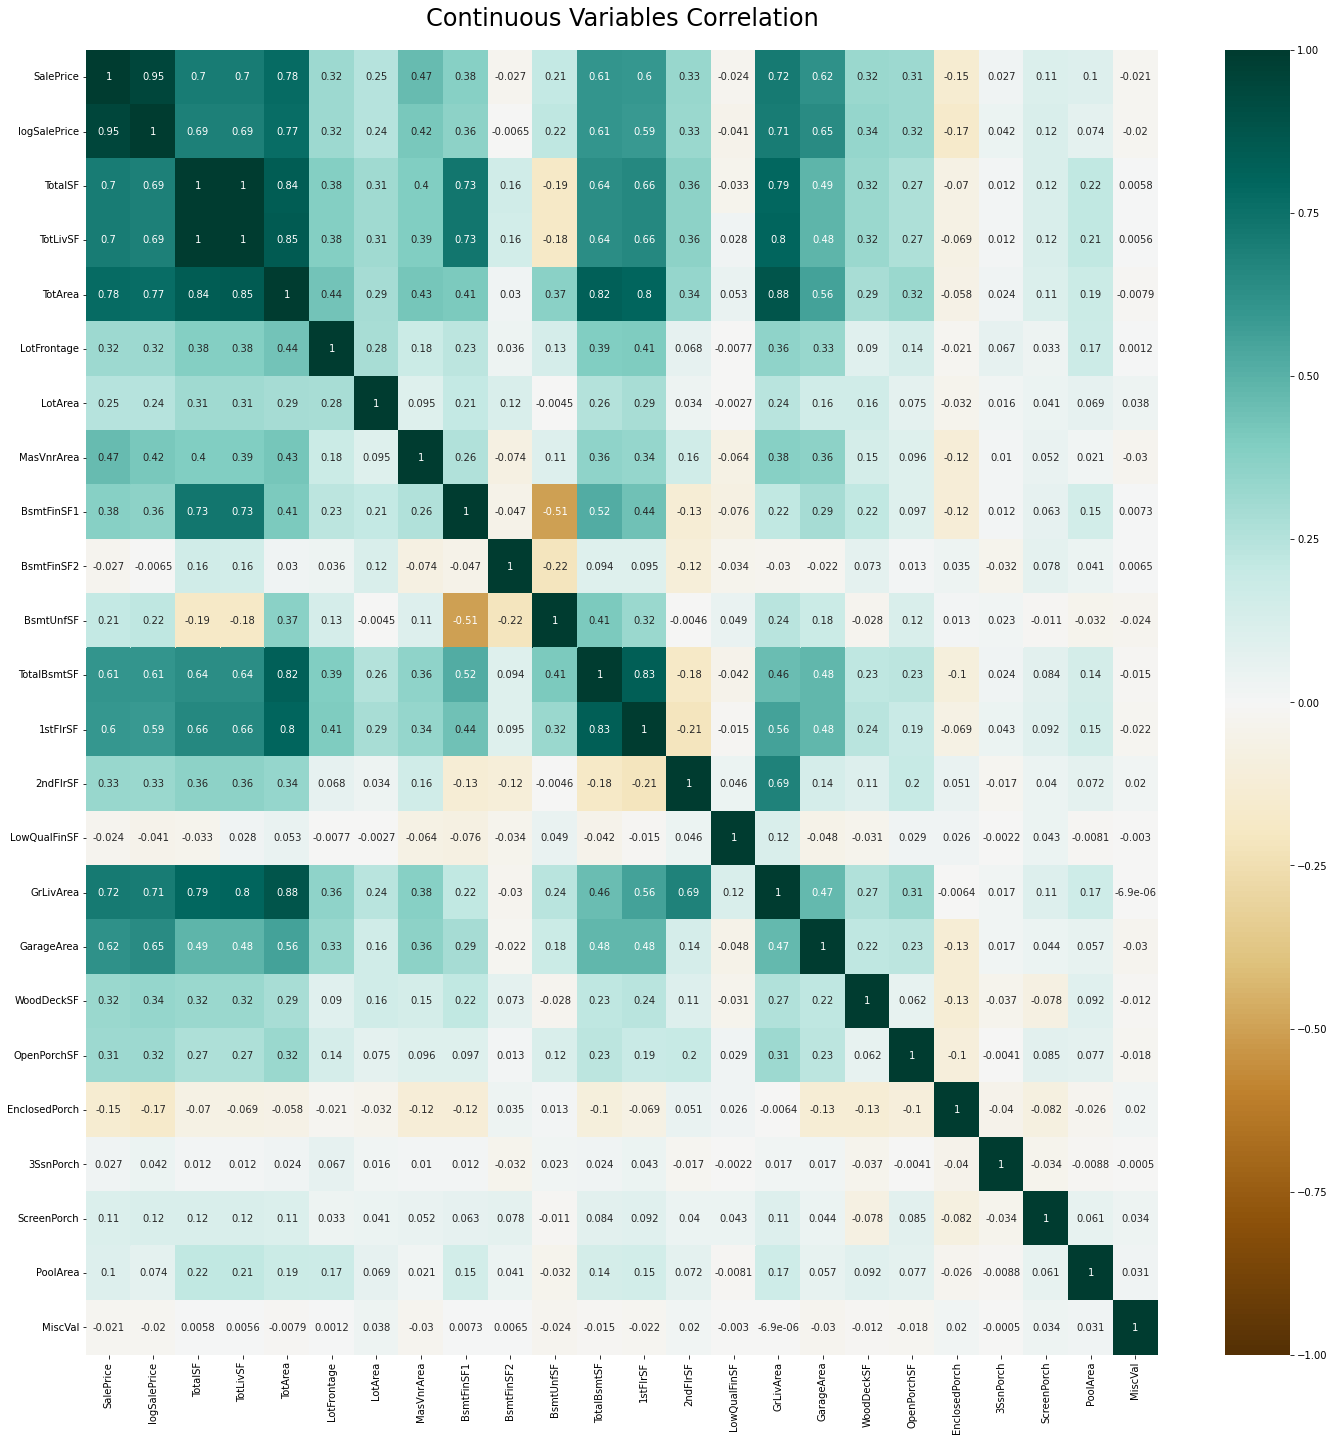

In [ ]:
# create correlation heatmap
plt.figure(figsize=(24, 24))
continuousHeatmap = sns.heatmap(continuousDF.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
continuousHeatmap.set_title('Continuous Variables Correlation', fontdict={'fontsize':24}, pad=24);

COMMENT:  The newly-created 'TotArea' variable has the highest correlation with 'SalePrice' and 'logSalePrice' response variables as compared to the similar 'GrLivArea', 'TotalSF' and 'TotLivSF' variables. 'GarageArea' is also well-correlated with 'SalePrice' and 'logSalePrice', but it is also well-correlated with 'TotArea', so it will not be considered further.

**Polynomial and Piece-Wise representations of the 'TotArea' variable**

A basic scatterplot of 'logSalePrice' vs. 'TotArea' is shown below.

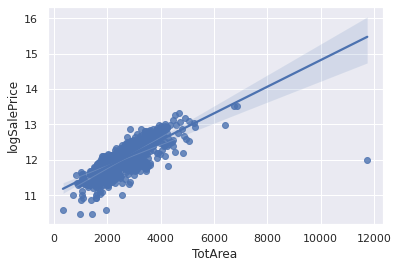

In [ ]:
# create scatterplot of logSalePrice vs. TotArea
sns.set(font_scale = 1)
ax = sns.regplot(x='TotArea', y='logSalePrice', data=continuousDF)

COMMENT:  The scatterplot clearly shows samples that are probably outliers and should be removed.

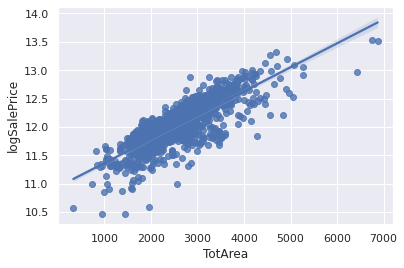

In [ ]:
continuousDF_a = continuousDF[continuousDF['TotArea'] <= 7500]
trainDF_a = trainDF[trainDF['TotArea'] <= 7500]

# create new scatterplot of logSalePrice vs. TotArea
sns.set(font_scale = 1)
ax = sns.regplot(x='TotArea', y='logSalePrice', data=continuousDF_a)

In [ ]:
# function to standardize dataframe columns
#  (zero mean, unit std deviation, assumed normal distribution)
def standardize(df):

  dtypes = list(zip(df.dtypes.index, map(str, df.dtypes)))

  # normalize numeric columns.
  for column, dtype in dtypes:
          df[column] -= df[column].mean()
          df[column] /= df[column].std()
  return df

In [ ]:
# use sci-kit LinearRegression to generate basic model in the scatterplot
y = continuousDF_a.logSalePrice
X = continuousDF_a[['TotArea']].copy()
Xstd = standardize(X)
model = LinearRegression()
model.fit(Xstd, y)
b1 = model.coef_
b0 = model.intercept_
print('Intercept coeff (b0) =', b0)
print('Slope coeff (b1) =', b1)
R2 = model.score(X,y)
print('Coeff of determination (R2) =', R2)

Intercept coeff (b0) = 12.024657400012343
Slope coeff (b1) = [0.32625055]
Coeff of determination (R2) = 0.6705215210835771


Try again, but include a quadratic term to the model

In [ ]:
# create dataframe with linear and quadratic terms
XX = continuousDF_a[['TotArea']].copy()
XX['TotArea2'] = continuousDF_a.TotArea * continuousDF_a.TotArea
XX.head()

,TotArea,TotArea2
0,2566,6584356
1,2524,6370576
3,2473,6115729
4,3343,11175649
5,2158,4656964


In [ ]:
XXstd = standardize(XX)
XXstd.head()

,TotArea,TotArea2
0,0.001670,-0.128807
1,-0.052622,-0.175376
3,-0.118548,-0.230891
4,1.006074,0.871340
5,-0.525738,-0.548661


In [ ]:
# use sci-kit LinearRegression
model = LinearRegression()
model.fit(XXstd, y)
b0 = model.intercept_
coeffs = model.coef_
print('Intercept coeff (b0) =', b0)
print('Linear (b1) and Quadratic (b2) term coeffs are', coeffs)
R2 = model.score(XX,y)
print('Coeff of determination (R2) =', R2)

Intercept coeff (b0) = 12.024657400012343
Linear (b1) and Quadratic (b2) term coeffs are [ 0.4824828  -0.16080486]
Coeff of determination (R2) = 0.6796539121369036


COMMENT:  Note that R2 is improved slightly when the quadratic term is included as compared to when it is not included.

**Now explore a piece-wise representation:**

Maximum iteration reached.

Fitted x-values =  [ 334.         2673.17837055 6872.        ]
Corresponding fitted y-values = [10.94531138 12.11621335 13.60479378]
x-axis breakpoint(s) =  [2673.17837055]


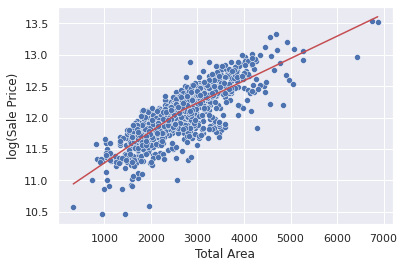

In [ ]:
# based upon the original scatterplot, make initial guess for breakpoint(s)
# (on the TotArea axis)
initialBreakpoints = [2500]  # assumes only 1 breakpoint at TotArea = 2500

# function to determine where optimal breakpoints occur

# code was originally generated and described in
# Muggeo, V. M. (2003),
#   "Estimating regression models with unknown breakpoints,"
#    Statistics in medicine, 22(19), 3055-3071.
from numpy.linalg import lstsq

ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

def SegmentedLinearReg( X, Y, breakpoints ):
    nIterationMax = 10

    breakpoints = np.sort( np.array(breakpoints) )

    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        A = np.array([ ones, X ] + Rk + Sk )
        p =  lstsq(A.transpose(), Y, rcond=None)[0] 

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck 

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break

        breakpoints = newBreakpoints
    else:
        print( 'Maximum iteration reached.\n' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution) 
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )

    return Xsolution, Ysolution, breakpoints

# the data ...
X = np.array(continuousDF_a['TotArea'])
Y = np.array(continuousDF_a['logSalePrice'])

# create fitted line segments that change at the breakpoint(s)
fittedX, fittedY, fittedBreakpoints = SegmentedLinearReg( X, Y, initialBreakpoints )

# print out the values of fittedX
print("Fitted x-values = ", fittedX)

# print out the values of fittedY
print("Corresponding fitted y-values =", fittedY)

# print out the values of the breakpoint(s)
print("x-axis breakpoint(s) = ", fittedBreakpoints)

# plot the data and fitted line segments
sns.set(font_scale = 1)
chart = sns.scatterplot(
    data=continuousDF_a,
    x='TotArea', y='logSalePrice',
)
chart.set(ylabel='log(Sale Price)')
chart.set(xlabel='Total Area')
plt.plot( fittedX, fittedY, '-r' );

COMMENT:  The piecewise scatterplot adjusts to fit the data, but it also requires two different linearizations of the data, which might make it less convenient as compared to just adding a quadratic term to adjust the fit.

### DISCRETE/INTERVALLIC VARIABLES

In [ ]:
# create dataframe with intervallic variables + response variable
#   note that GarageYrBlt(61) has missing values
intervalDF = trainDF_a[['logSalePrice','YearBuilt','YearRemodAdd','BsmtFullBath','BsmtHalfBath',
                         'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                         'TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','YearMoSold']]

# impute missing values ('GarageYrBlt') with median value
intervalDF = intervalDF.fillna(intervalDF.median())
intervalDF.head()

,logSalePrice,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,YearMoSold
0,12.247694,2003,2003,1,0,2,1,3,1,8,0,2003.0,2,2008.166667
1,12.109011,1976,1976,0,1,2,0,3,1,6,1,1976.0,2,2007.416667
3,11.849398,1915,1970,1,0,1,0,3,1,7,1,1998.0,3,2006.166667
4,12.429216,2000,2000,1,0,2,1,4,1,9,1,2000.0,3,2009.000000
5,11.870600,1993,1995,1,0,1,1,1,1,5,0,1993.0,2,2009.833333


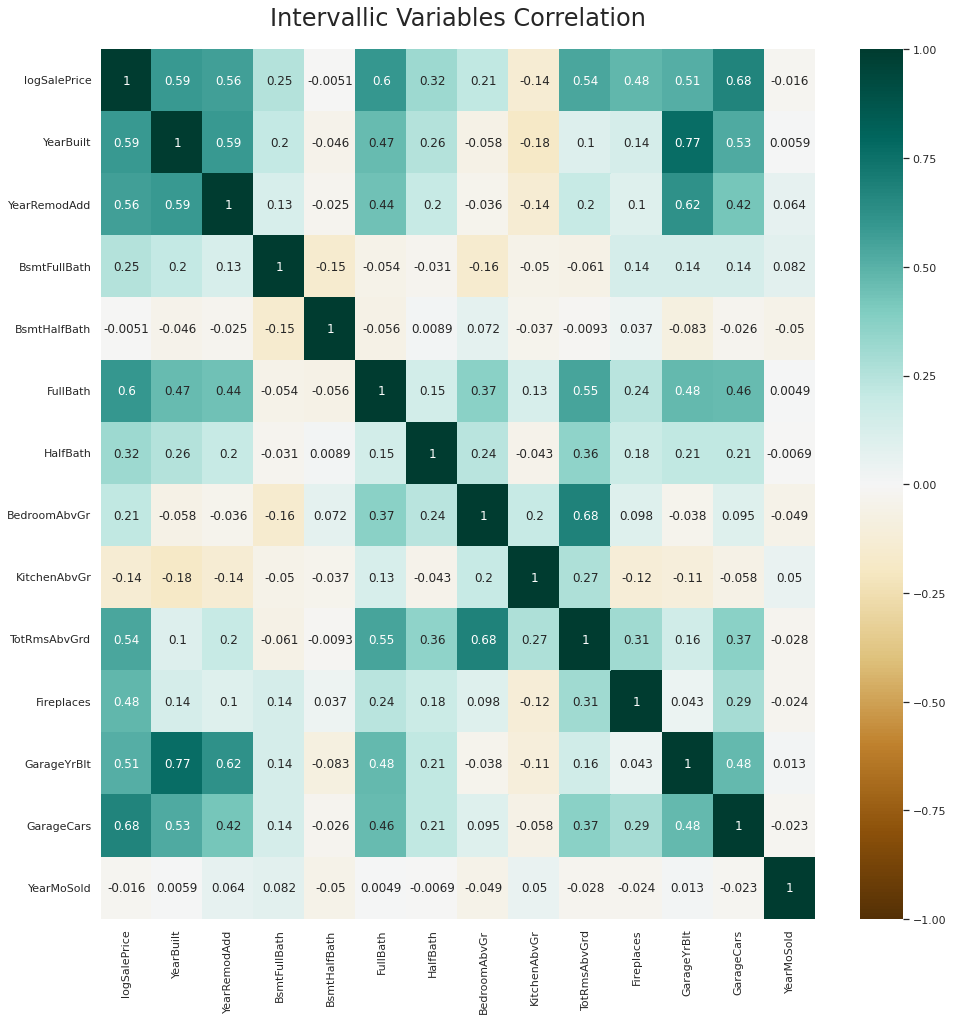

In [ ]:
# create correlation heatmap
plt.figure(figsize=(16, 16))
intervallicHeatmap = sns.heatmap(intervalDF.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
intervallicHeatmap.set_title('Intervallic Variables Correlation', fontdict={'fontsize':24}, pad=24);

COMMENT:  In this correlation map, the highest correlation with 'logSalePrice' is with 'GarageCars' (i.e., garage size in terms of the number of cars it can hold).  Note that this was observed earlier with the continuous variables, where 'GarageArea' was a variable, and in that case, 'GarageArea' was not selected since it had signification correlation with 'TotArea'.

Other variables possessing high correlation with 'logSalePrice' are 'YearBuilt' and 'YearRemodeled' (i.e., newer homes or newly-remodeled homes exhibited higher sales prices).  However, these two variables have high correlation, so only one ('YearBuilt') will be selected for further evaluation.

### ORDINAL VARIABLES

These variables possess an inherent ordering of "goodness", but are not strictly intervallic.  However, to simplify things in this analysis, these variables were assumed to possess sufficient "intervallic-ness" such that they can be treated as if they were intervallic.

Note that the levels in most of these variables are designated by text descriptors and not numbers.  For those variables, the text descriptors were converted to integers such that they could be treated as numeric variables and correlation values could be obtained.

In [ ]:
# create dataframe with ordinal variables (15 variables)

# note that BsmtQual(32), BsmtCond(32), BsmtExposure(33), BsmtFinType1(32), BsmtFinType2(33),
#  GarageFinish(61), GarageQual(61) and GarageCond(61) have NAs
#  (where the NANs are not necessarily missing values but might represent not applicable values)

# changing categorical to numeric ordinal values:
# (for cateories with NAs, have to change to numeric first and then impute NA with median value)
#   OverallQual, OverallCond are ranked 1(low)-10(high) already
#   ExterQual, ExterCond are ranked {Ex, Gd, TA, Fa, Po} ==> change to {5,4,3,2,1}
#   BsmtQual, BsmtCond are ranked {Ex,Gd,TA,Fa,Po,NA} ==> change to {5,4,3,2,1,median}
#   BsmtExposure is ranked {Gd,Av,Mn,No,NA} ==> change to {4,3,2,1,median}
#   BsmtFinType1/2 are ranked {GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA}
#     ==> change to {4,3,2,3,1,1,median}
#   HeatingQC is ranked {Ex,Gd,TA,Fa,Po} ==> change to {5,4,3,2,1}
#   KitchenQual is ranked {Ex, Gd, TA, Fa, Po} ==> change to {5,4,3,2,1}
#   Functional ranked {Typ,Min1,Min2,Mod,Maj1,Maj2,Sev,Sal} ==> change to {5,4,4,3,2,2,1,0}
#   FireplaceQu (ELIMINATED ALREADY)
#   GarageFinish is ranked {Fin, RFn, Unf, NA} ==> change to {3,2,1,median}
#   GarageQual is ranked {Ex,Gd,TA,Fa,Po,NA} ==> change to {5,4,3,2,1,median}
#   GarageCond is ranked {Ex,Gd,TA,Fa,Po,NA} ==> change to {5,4,3,2,1,median}
#   PoolQC (ELIMINATED ALREADY)

ordinalDF = trainDF_a[['OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual',
                         'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                         'HeatingQC','KitchenQual','Functional',
                         'GarageFinish','GarageQual','GarageCond']]
ordinalDF.head()

,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond
0,7,5,Gd,TA,Gd,TA,No,GLQ,Unf,Ex,Gd,Typ,RFn,TA,TA
1,6,8,TA,TA,Gd,TA,Gd,ALQ,Unf,Ex,TA,Typ,RFn,TA,TA
3,7,5,TA,TA,TA,Gd,No,ALQ,Unf,Gd,Gd,Typ,Unf,TA,TA
4,8,5,Gd,TA,Gd,TA,Av,GLQ,Unf,Ex,Gd,Typ,RFn,TA,TA
5,5,5,TA,TA,Gd,TA,No,GLQ,Unf,Ex,TA,Typ,Unf,TA,TA


In [ ]:
# function to define numerical values (0-5) of "goodness" for different categories
def qualityNames_to_number(qualVal):
    if qualVal == 'Ex':
        return 5
    elif qualVal == 'Typ':
        return 5
    elif qualVal == 'Gd':
        return 4
    elif qualVal == 'Min1':
        return 4
    elif qualVal == 'Min2':
        return 4
    elif qualVal == 'GLQ':
        return 4
    elif qualVal == 'TA':
        return 3
    elif qualVal == 'Av':
        return 3
    elif qualVal == 'Fin':
        return 3
    elif qualVal == 'Mod':
        return 3
    elif qualVal == 'ALQ':
        return 3
    elif qualVal == 'Rec':
        return 3
    elif qualVal == 'Fa':
        return 2
    elif qualVal == 'Mn':
        return 2
    elif qualVal == 'Maj1':
        return 2
    elif qualVal == 'Maj2':
        return 2
    elif qualVal == 'RFn':
        return 2
    elif qualVal == 'BLQ':
        return 2
    elif qualVal == 'Po':
        return 1
    elif qualVal == 'No':
        return 1
    elif qualVal == 'Unf':
        return 1
    elif qualVal == 'Sev':
        return 1
    elif qualVal == 'LwQ':
        return 1
    elif qualVal == 'Sev':
        return 1
    elif qualVal == 'Sal':
        return 0
    elif np.isnan(qualVal):
        pass # don't do anything
    else: 
        return 'ERROR'

oldColNames = ('ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',
               'BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual',
               'Functional','GarageFinish','GarageQual','GarageCond')

newColNames = ('ExterQualNum','ExterCondNum','BsmtQualNum','BsmtCondNum',
               'BsmtExposureNum','BsmtFinType1Num','BsmtFinType2Num',
                'HeatingQCNum','KitchenQualNum','FunctionalNum',
                'GarageFinishNum','GarageQualNum','GarageCondNum')


for aa in range(len(oldColNames)):
    oldName = oldColNames[aa]
    newName = newColNames[aa]
    ordinalDF[newName] = ordinalDF.loc[:,oldName].apply(qualityNames_to_number)
    #ordinalDF[newName] = ordinalDF[oldName].apply(qualityNames_to_number)
    
# drop the old (non-numeric) categories
ordinalNumDF = ordinalDF.select_dtypes(exclude=['object'])

# impute missing values with median value
ordinalNumDF = ordinalNumDF.fillna(ordinalNumDF.median())

# add the 'logSalePrice' column
ordinalNumDF['logSalePrice'] = trainDF_a[['logSalePrice']]
ordinalNumDF.head(25)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,OverallQual,OverallCond,ExterQualNum,ExterCondNum,BsmtQualNum,BsmtCondNum,BsmtExposureNum,BsmtFinType1Num,BsmtFinType2Num,HeatingQCNum,KitchenQualNum,FunctionalNum,GarageFinishNum,GarageQualNum,GarageCondNum,logSalePrice
0,7,5,4,3,4.0,3.0,1.0,4.0,1.0,5,4,5,2.0,3.0,3.0,12.247694
1,6,8,3,3,4.0,3.0,4.0,3.0,1.0,5,3,5,2.0,3.0,3.0,12.109011
3,7,5,3,3,3.0,4.0,1.0,3.0,1.0,4,4,5,1.0,3.0,3.0,11.849398
4,8,5,4,3,4.0,3.0,3.0,4.0,1.0,5,4,5,2.0,3.0,3.0,12.429216
5,5,5,3,3,4.0,3.0,1.0,4.0,1.0,5,3,5,1.0,3.0,3.0,11.870600
7,7,6,3,3,4.0,3.0,2.0,3.0,2.0,5,3,5,2.0,3.0,3.0,12.206073
8,7,5,3,3,3.0,3.0,1.0,1.0,1.0,4,3,4,1.0,2.0,3.0,11.774520
10,5,5,3,3,3.0,3.0,1.0,3.0,1.0,5,3,5,1.0,3.0,3.0,11.771436
11,9,5,5,3,5.0,3.0,1.0,4.0,1.0,5,5,5,3.0,3.0,3.0,12.751300
12,5,6,3,3,3.0,3.0,1.0,3.0,1.0,3,3,5,1.0,3.0,3.0,11.877569


Text(0.5, 1.0, 'Ordinal Variables Correlation')

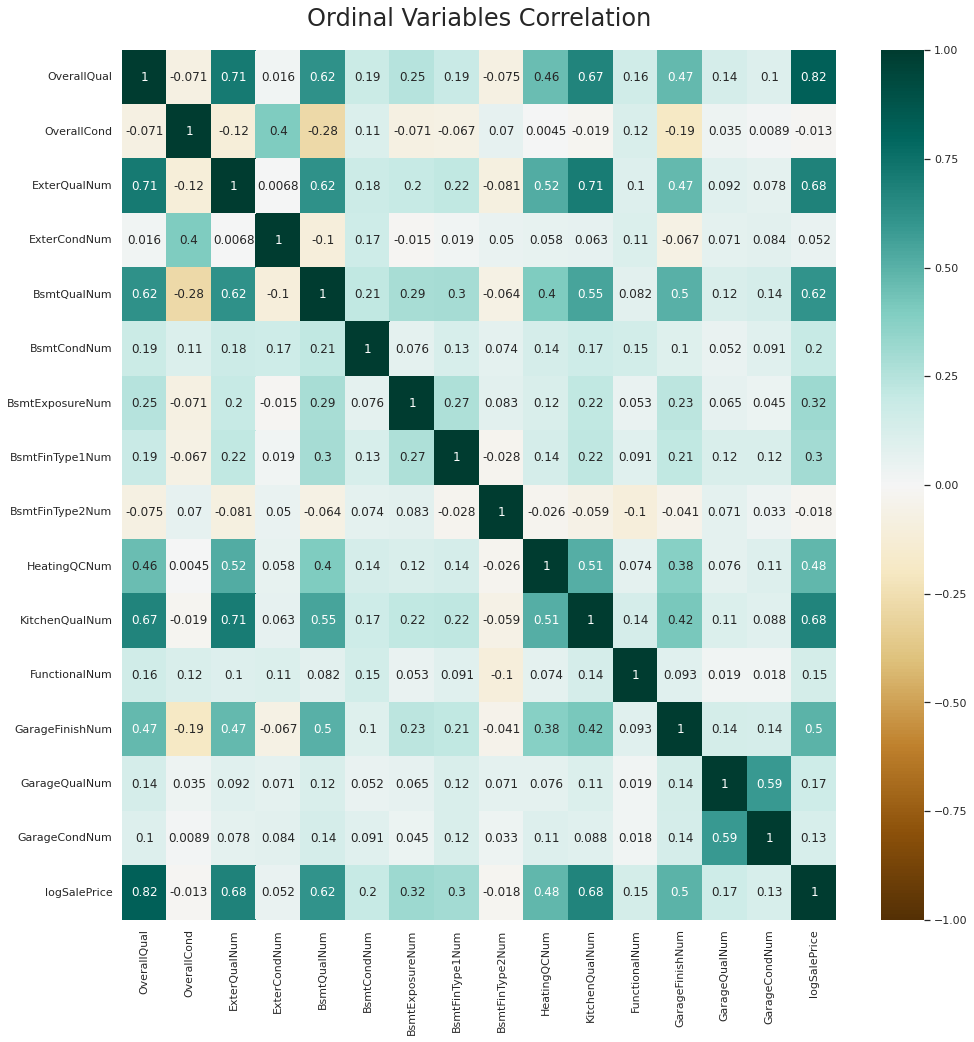

In [ ]:
# create correlation heatmap
plt.figure(figsize=(16, 16))
ordinalHeatmap = sns.heatmap(ordinalNumDF.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
ordinalHeatmap.set_title('Ordinal Variables Correlation', fontdict={'fontsize':24}, pad=24)

COMMENT:  'OverallQual' exhibits the highest correlation with 'logSalePrice'.  It is also highly correlated with the next several ordinal variables that possess relatively high correlation with 'logSalePrice' (BsmtQual, ExterQual and KitchenQual).  Therefore, only 'OverallQual' was selected for further evaluation from these ordinal variables.

### NON-ORDINAL, CATEGORICAL VARIABLES

These variables are not numeric, nor do they possess an inherent order of "goodness".  Swarmplots were created to visually evaluate the distributions of these variables with respect to 'logSalePrice'.

In [ ]:
# create tuple of column names
catColNames = ('MSSubClass','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope',
'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st',
'Exterior2nd','Foundation','Heating','Electrical','GarageType','PavedDrive','SaleType')

In [ ]:
# create dataframe with non-ordinal categorical variables (23 variables)
#   note that Electrical and GarageType have missing values

categoricalDF = trainDF_a[['MSSubClass','MSZoning','Street','LotShape','LandContour',
                          'Utilities','LotConfig','LandSlope','Neighborhood','Condition1',
                          'Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl',
                          'Exterior1st','Exterior2nd','Foundation','Heating',
                          'Electrical','GarageType','PavedDrive','SaleType']].copy()

# impute the one Electrical missing value with most frequent (i.e., mode)
categoricalDF.Electrical = categoricalDF.Electrical.fillna(categoricalDF.Electrical.mode()[0])

# for the 61 missing GarageType, assume NaN means there is no garage ==> impute with 'None'
categoricalDF.GarageType = categoricalDF.GarageType.fillna('None')

# add the 'logSalePrice' column
categoricalDF['logSalePrice'] = trainDF_a['logSalePrice']
categoricalDF.head()

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,Foundation,Heating,Electrical,GarageType,PavedDrive,SaleType,logSalePrice
0,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,PConc,GasA,SBrkr,Attchd,Y,WD,12.247694
1,20,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,CBlock,GasA,SBrkr,Attchd,Y,WD,12.109011
3,70,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,BrkTil,GasA,SBrkr,Detchd,Y,WD,11.849398
4,60,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,PConc,GasA,SBrkr,Attchd,Y,WD,12.429216
5,50,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,VinylSd,VinylSd,Wood,GasA,SBrkr,Attchd,Y,WD,11.870600


In [ ]:
catColNames = categoricalDF.columns.values.tolist()
catColNames.remove('logSalePrice')
print(catColNames)
len(catColNames)

['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'PavedDrive', 'SaleType']


23

In [ ]:
# generate swarmplots for the different categories in each categorical variable
sns.set(font_scale = 2)  # set font scale
rowIndex = 0
colIndex = 0
for aa in range(len(catColNames)):
    chart = sns.catplot(
        data=categoricalDF,
        x=catColNames[aa], y='logSalePrice',
        kind='swarm',
        palette='Set1',
        height=9, aspect=3,
        s=4
    )
    chart.set_xticklabels(rotation=45)
    chart.set(ylabel='log(SalePrice)')
 
sns.set(font_scale = 1)  # reset font scale

Output hidden; open in https://colab.research.google.com to view.

COMMENT:  In evaluating the swarmplots, it is desired to have variables that 1) exhibit good distribution of the samples across the different categories (i.e., the vast majority of samples are not contained in only 1 or 2 categories), and 2) have notable variation in 'SalePrice' that is related to the category in which samples reside.

'Neighborhood' ("Location, Location, Location") and possibly 'MSSubClass' (the type of dwelling -- single family home, etc.) appear to represent these desired characteristics the best.  However, these variables have a relatively large number of categories, and these numbers should be reduced to make an eventual model more practical.

To reduce the number fo different categories, the descriptive statistics of individual categories will be used to create vectors and then vectors with similar statistics will be combined using k-means clustering.

**Using k-means clustering to reduce the number of different levels in 'Neighborhood'**

In [ ]:
# create new dataframe with dependent and independent variable
neighborhoodDF = categoricalDF[['logSalePrice','Neighborhood']].copy()
neighborhoodDF.shape

(1167, 2)

In [ ]:
# display DF
neighborhoodDF.head()

,logSalePrice,Neighborhood
0,12.247694,CollgCr
1,12.109011,Veenker
3,11.849398,Crawfor
4,12.429216,NoRidge
5,11.870600,Mitchel


In [ ]:
# count how many unique categories in variable 'Neighborhood'
nNeighborhoods = neighborhoodDF['Neighborhood'].nunique()
nNeighborhoods

25

In [ ]:
# create a Series of the neighborhood names
neighborhoodNames = neighborhoodDF['Neighborhood'].unique()

# names of the default descriptive stats (used to create indices of DF below)
rowNames = ["count","mean","std","min","25%","50%","75%","max"]

# initialize a dataframe to store the SalePrice ($K) statistics of each neighborhood region
neighStatsDF = pd.DataFrame(index=rowNames, columns=neighborhoodNames)

# populate the dataframe
for i in range(0, nNeighborhoods):
    
    # get the name of a neighborhood region
    regionName = neighborhoodNames[i]
    
    # get the rows in NeighborhoodDF that have this region
    rowsWithRegionOfInterestDF = neighborhoodDF.loc[neighborhoodDF['Neighborhood']==regionName]
    
    # extract the logSalePrice column from this new dataframe
    logSalePricesForThisRegion = rowsWithRegionOfInterestDF['logSalePrice']
    
    # get the descriptive statistics of the logSalePrice for this region
    #  and store statistics as dataframe column
    neighStatsDF.iloc[:,i] = logSalePricesForThisRegion.describe()

neighStatsDF

,CollgCr,Veenker,Crawfor,NoRidge,Mitchel,NWAmes,OldTown,Sawyer,NridgHt,BrkSide,NAmes,IDOTRR,Edwards,Timber,SawyerW,Somerst,StoneBr,ClearCr,MeadowV,Gilbert,NPkVill,BrDale,Blmngtn,SWISU,Blueste
count,114.000000,9.000000,34.000000,34.000000,42.000000,59.000000,95.000000,59.000000,62.000000,48.000000,187.000000,28.000000,76.000000,33.000000,45.000000,74.000000,22.000000,20.000000,11.000000,61.000000,7.000000,12.000000,13.000000,20.000000,2.000000
mean,12.165183,12.309564,12.168374,12.669598,11.945707,12.141855,11.725105,11.818480,12.595949,11.655088,11.868978,11.451746,11.674780,12.373398,12.114747,12.304014,12.559784,12.280373,11.438869,12.156652,11.859161,11.560465,12.196293,11.817261,11.826536
std,0.243428,0.253659,0.325260,0.290644,0.233591,0.211123,0.322855,0.181643,0.302456,0.354308,0.203845,0.438441,0.283804,0.258413,0.316463,0.247064,0.336772,0.221614,0.232483,0.145646,0.075372,0.139814,0.158312,0.279603,0.139299
min,11.630709,11.998433,11.411446,12.154779,11.344507,11.320554,10.868568,11.041048,11.944708,10.578980,11.379394,10.460242,11.002100,11.982929,11.238489,11.878624,12.043554,11.775290,11.225243,11.884489,11.755872,11.326596,11.982273,11.002100,11.728037
25%,11.956818,12.109011,11.924776,12.478946,11.795736,12.052300,11.570722,11.763677,12.376946,11.483792,11.766986,11.338356,11.512675,12.141534,11.898188,12.100970,12.296970,12.151468,11.295993,12.072541,11.804592,11.418569,12.093688,11.734624,11.777286
50%,12.191967,12.292250,12.123377,12.617354,11.963664,12.128111,11.711776,11.813030,12.650415,11.699396,11.849398,11.582893,11.678440,12.337101,12.149502,12.332044,12.529951,12.345598,11.344507,12.106252,11.891362,11.598724,12.167851,11.840207,11.826536
75%,12.320729,12.506177,12.366275,12.754144,12.049419,12.248875,11.849398,11.914550,12.789658,11.821923,11.976659,11.740061,11.847252,12.567237,12.339291,12.446756,12.830641,12.418154,11.535651,12.206073,11.903264,11.678440,12.278393,11.980271,11.875786
max,12.858320,12.688499,12.880292,13.534473,12.509874,12.610871,13.071070,12.154779,13.323927,12.317167,12.751300,12.040608,12.524417,12.843971,12.676076,12.955127,13.195614,12.618182,11.927681,12.676076,11.951180,11.736069,12.485827,12.206073,11.925035


In [ ]:
# remove the 1st row (counts) from statsDF
neighStatsDF_a = neighStatsDF.iloc[1: , :]
neighStatsDF_a

,CollgCr,Veenker,Crawfor,NoRidge,Mitchel,NWAmes,OldTown,Sawyer,NridgHt,BrkSide,NAmes,IDOTRR,Edwards,Timber,SawyerW,Somerst,StoneBr,ClearCr,MeadowV,Gilbert,NPkVill,BrDale,Blmngtn,SWISU,Blueste
mean,12.165183,12.309564,12.168374,12.669598,11.945707,12.141855,11.725105,11.818480,12.595949,11.655088,11.868978,11.451746,11.674780,12.373398,12.114747,12.304014,12.559784,12.280373,11.438869,12.156652,11.859161,11.560465,12.196293,11.817261,11.826536
std,0.243428,0.253659,0.325260,0.290644,0.233591,0.211123,0.322855,0.181643,0.302456,0.354308,0.203845,0.438441,0.283804,0.258413,0.316463,0.247064,0.336772,0.221614,0.232483,0.145646,0.075372,0.139814,0.158312,0.279603,0.139299
min,11.630709,11.998433,11.411446,12.154779,11.344507,11.320554,10.868568,11.041048,11.944708,10.578980,11.379394,10.460242,11.002100,11.982929,11.238489,11.878624,12.043554,11.775290,11.225243,11.884489,11.755872,11.326596,11.982273,11.002100,11.728037
25%,11.956818,12.109011,11.924776,12.478946,11.795736,12.052300,11.570722,11.763677,12.376946,11.483792,11.766986,11.338356,11.512675,12.141534,11.898188,12.100970,12.296970,12.151468,11.295993,12.072541,11.804592,11.418569,12.093688,11.734624,11.777286
50%,12.191967,12.292250,12.123377,12.617354,11.963664,12.128111,11.711776,11.813030,12.650415,11.699396,11.849398,11.582893,11.678440,12.337101,12.149502,12.332044,12.529951,12.345598,11.344507,12.106252,11.891362,11.598724,12.167851,11.840207,11.826536
75%,12.320729,12.506177,12.366275,12.754144,12.049419,12.248875,11.849398,11.914550,12.789658,11.821923,11.976659,11.740061,11.847252,12.567237,12.339291,12.446756,12.830641,12.418154,11.535651,12.206073,11.903264,11.678440,12.278393,11.980271,11.875786
max,12.858320,12.688499,12.880292,13.534473,12.509874,12.610871,13.071070,12.154779,13.323927,12.317167,12.751300,12.040608,12.524417,12.843971,12.676076,12.955127,13.195614,12.618182,11.927681,12.676076,11.951180,11.736069,12.485827,12.206073,11.925035


In [ ]:
# transpose the dataframe so that categories are the rows
neighStatsDFTrans = neighStatsDF_a.transpose()
neighStatsDFTrans

,mean,std,min,25%,50%,75%,max
CollgCr,12.165183,0.243428,11.630709,11.956818,12.191967,12.320729,12.858320
Veenker,12.309564,0.253659,11.998433,12.109011,12.292250,12.506177,12.688499
Crawfor,12.168374,0.325260,11.411446,11.924776,12.123377,12.366275,12.880292
NoRidge,12.669598,0.290644,12.154779,12.478946,12.617354,12.754144,13.534473
Mitchel,11.945707,0.233591,11.344507,11.795736,11.963664,12.049419,12.509874
NWAmes,12.141855,0.211123,11.320554,12.052300,12.128111,12.248875,12.610871
OldTown,11.725105,0.322855,10.868568,11.570722,11.711776,11.849398,13.071070
Sawyer,11.818480,0.181643,11.041048,11.763677,11.813030,11.914550,12.154779
NridgHt,12.595949,0.302456,11.944708,12.376946,12.650415,12.789658,13.323927
BrkSide,11.655088,0.354308,10.578980,11.483792,11.699396,11.821923,12.317167


In [ ]:
# inmpute any missing values (e.g., std deviations of categories with only
#  one variable) with a very low, near-zero value
neighStatsDFTrans = neighStatsDFTrans.fillna(0.000001)
neighStatsDFTrans

,mean,std,min,25%,50%,75%,max
CollgCr,12.165183,0.243428,11.630709,11.956818,12.191967,12.320729,12.858320
Veenker,12.309564,0.253659,11.998433,12.109011,12.292250,12.506177,12.688499
Crawfor,12.168374,0.325260,11.411446,11.924776,12.123377,12.366275,12.880292
NoRidge,12.669598,0.290644,12.154779,12.478946,12.617354,12.754144,13.534473
Mitchel,11.945707,0.233591,11.344507,11.795736,11.963664,12.049419,12.509874
NWAmes,12.141855,0.211123,11.320554,12.052300,12.128111,12.248875,12.610871
OldTown,11.725105,0.322855,10.868568,11.570722,11.711776,11.849398,13.071070
Sawyer,11.818480,0.181643,11.041048,11.763677,11.813030,11.914550,12.154779
NridgHt,12.595949,0.302456,11.944708,12.376946,12.650415,12.789658,13.323927
BrkSide,11.655088,0.354308,10.578980,11.483792,11.699396,11.821923,12.317167


In [ ]:
# min-max the columns so that all statistic vector elements are weighted equally
neighStatsDFTrans_scaled = MinMaxScaler().fit_transform(neighStatsDFTrans)

In [ ]:
# use of k-means to combine neighborhoods with similar statistics

# determine optimal value for K
distortions = []
inertias = []

K = range(1, nNeighborhoods)
for k in K:
    
    # building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(neighStatsDFTrans_scaled)
    kmeanModel.fit(neighStatsDFTrans_scaled)
    
    distortions.append(sum(np.min(cdist(neighStatsDFTrans_scaled,
                kmeanModel.cluster_centers_,'euclidean'),axis=1)) / neighStatsDFTrans_scaled.shape[0])
    inertias.append(kmeanModel.inertia_)

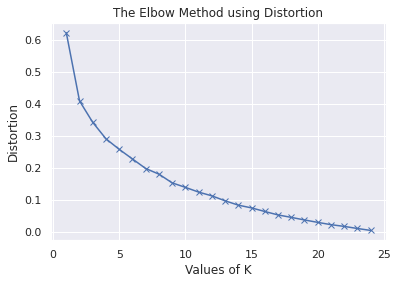

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

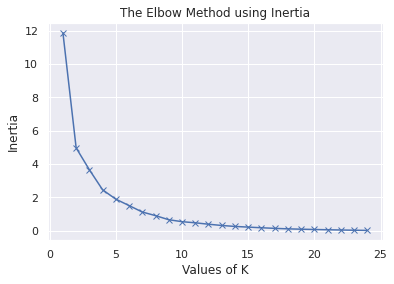

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

COMMENT:  The elbow curves suggest there is little improvement per additional "k" after about k=4 or k=5 clusters.

In [ ]:
# create new dataframe with Neighborhood-related columns
nbrHdClusterDF = neighborhoodDF[['logSalePrice','Neighborhood']].copy()

-----------------------------------------------------

In [ ]:
# specify value for k (k=4 clusters in this case)
nbrHd_k = 4

# determine which cluster each neighborhood belongs to
kmeans = KMeans(n_clusters = nbrHd_k,
        init = 'k-means++',
        random_state = 42)
y_kmeans_nbrHd4 = kmeans.fit_predict(neighStatsDFTrans_scaled)
neighStatsDFTrans['Cluster_4'] = y_kmeans_nbrHd4.tolist()

In [ ]:
# create dictionary to map Neighborhood category levels to the corresponding cluster number
nbrHd_clusterNum_Dict_4 = dict(zip(neighStatsDFTrans.index, neighStatsDFTrans.Cluster_4))

In [ ]:
# map the cluster numbers to the names of the different category levels
nbrHdClusterDF['nbrHdCluster_k4']=nbrHdClusterDF['Neighborhood'].map(nbrHd_clusterNum_Dict_4)

-----------------------------------------------

In [ ]:
# specify value for k (k=5 clusters in this case)
nbrHd_k = 5

# determine which cluster each neighborhood belongs to
kmeans = KMeans(n_clusters = nbrHd_k,
        init = 'k-means++',
        random_state = 42)
y_kmeans_nbrHd5 = kmeans.fit_predict(neighStatsDFTrans_scaled)
neighStatsDFTrans['Cluster_5'] = y_kmeans_nbrHd5.tolist()

In [ ]:
# create dictionary to map Neighborhood category levels to the corresponding cluster number
nbrHd_clusterNum_Dict_5 = dict(zip(neighStatsDFTrans.index, neighStatsDFTrans.Cluster_5))

In [ ]:
# map the cluster numbers to the names of the different category levels
nbrHdClusterDF['nbrHdCluster_k5']=nbrHdClusterDF['Neighborhood'].map(nbrHd_clusterNum_Dict_5)

-------------------------------

In [ ]:
# display the 'Neighborhood' cluster mapping dataframe showing k=4 and k=5 cluster mappings
nbrHdClusterDF.head(25)

,logSalePrice,Neighborhood,nbrHdCluster_k4,nbrHdCluster_k5
0,12.247694,CollgCr,1,3
1,12.109011,Veenker,1,3
3,11.849398,Crawfor,1,3
4,12.429216,NoRidge,2,1
5,11.870600,Mitchel,3,2
7,12.206073,NWAmes,1,3
8,11.774520,OldTown,0,4
10,11.771436,Sawyer,3,2
11,12.751300,NridgHt,2,1
12,11.877569,Sawyer,3,2


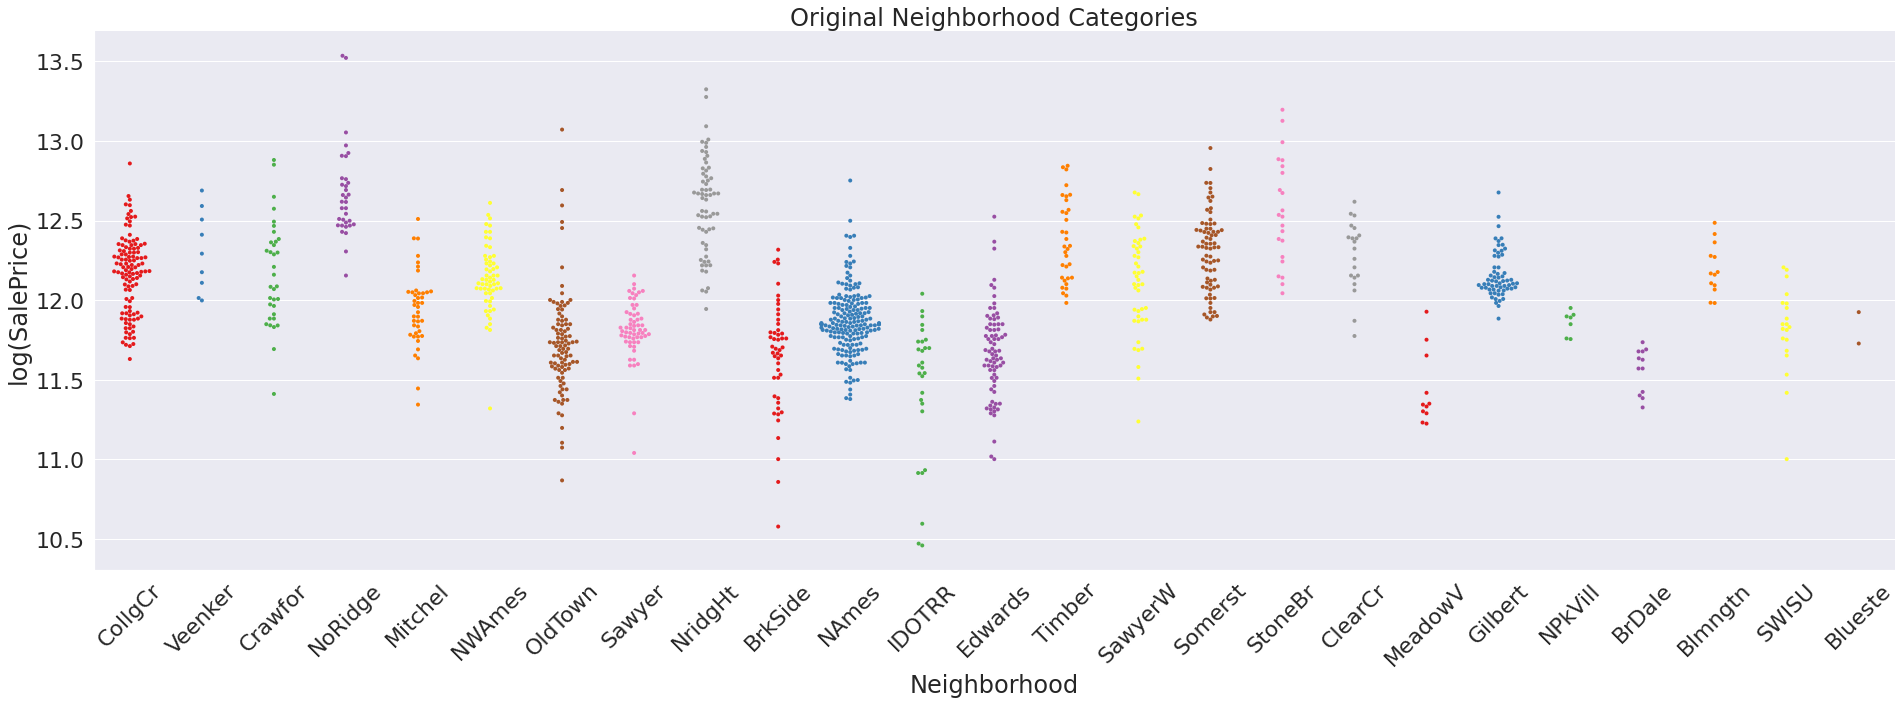

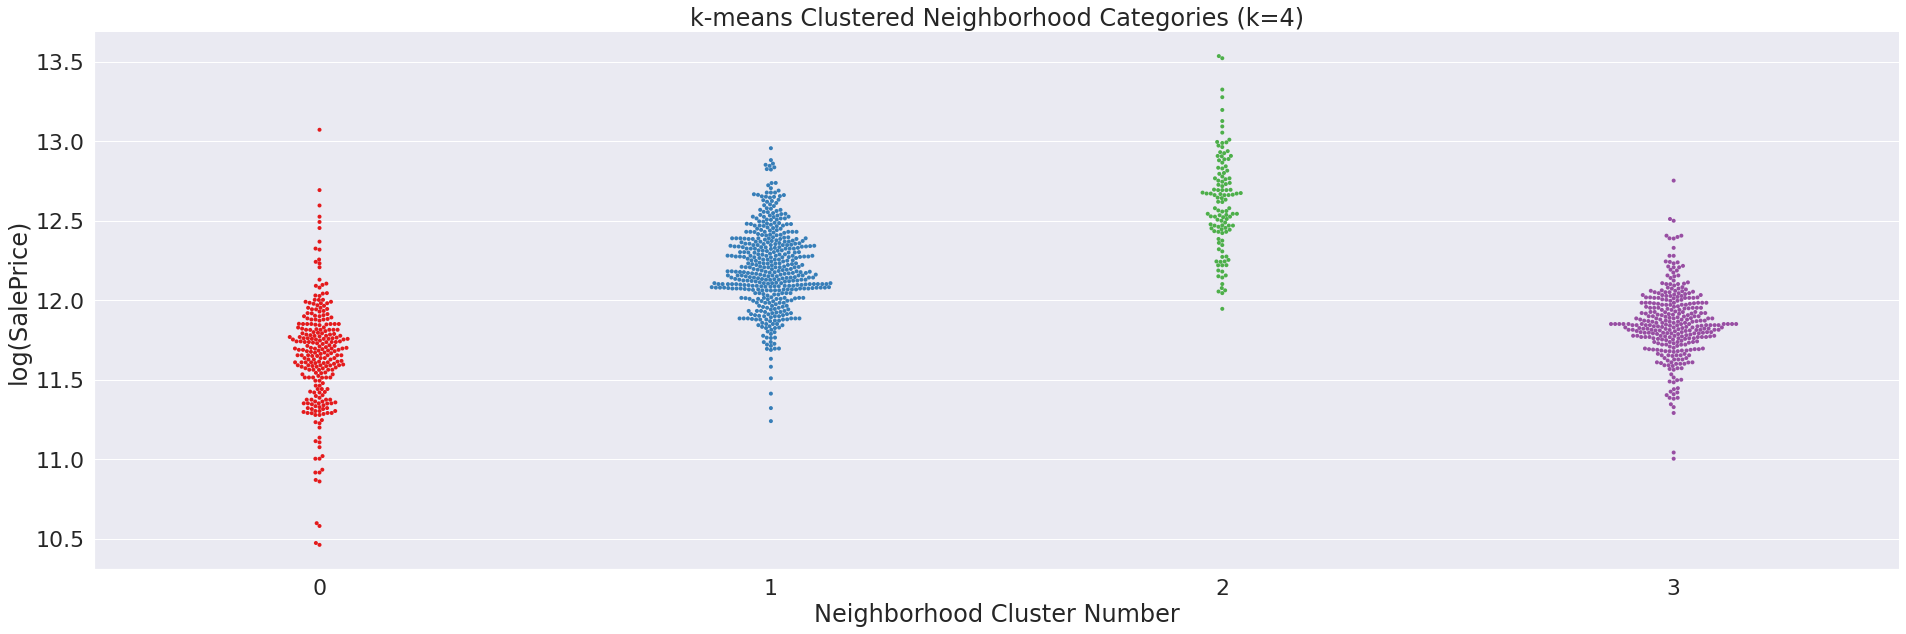

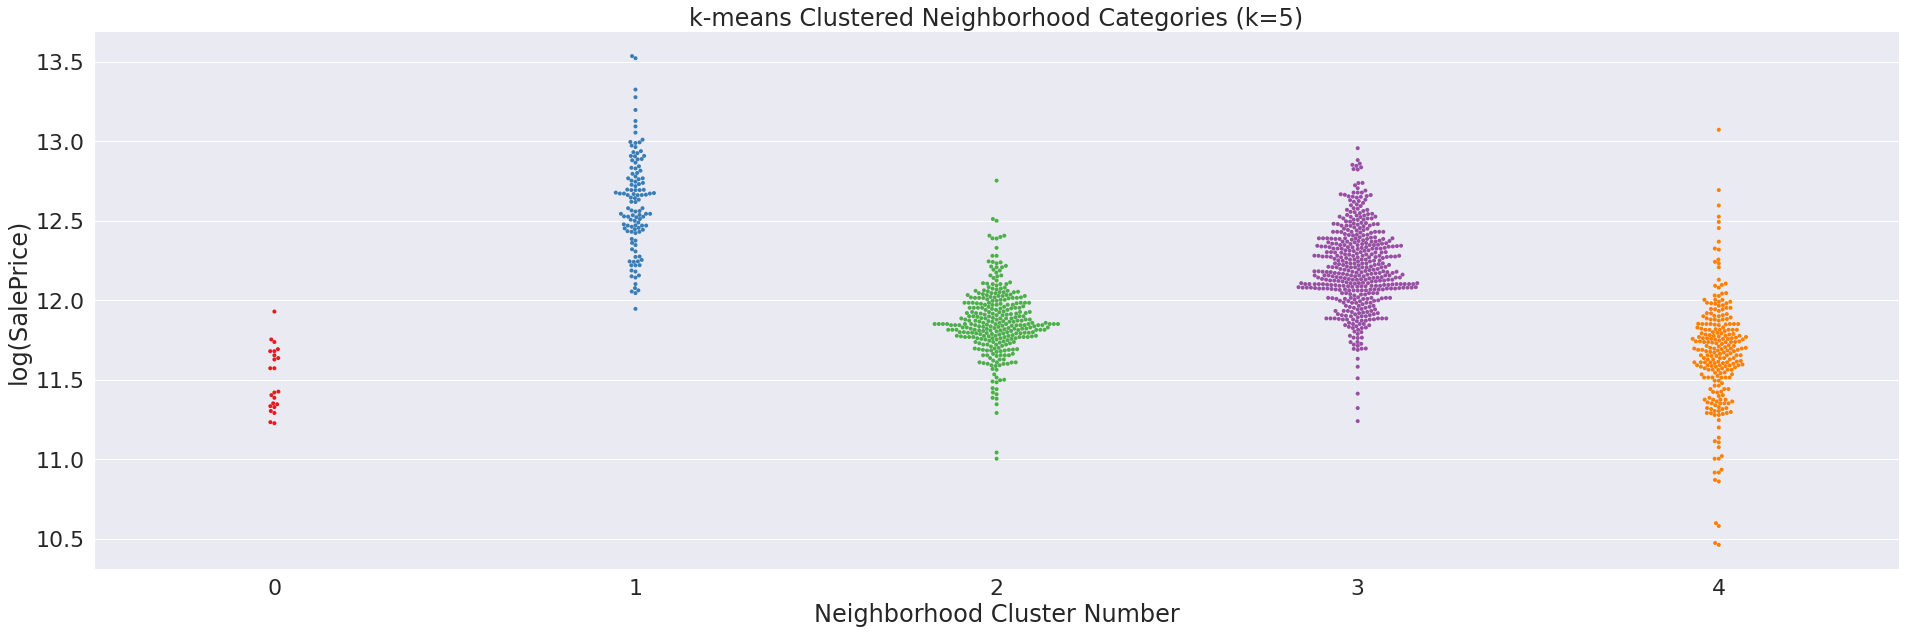

In [ ]:
# create swarm plots of the new 'Neighborhood' cluster categories

sns.set(font_scale = 2)  # set font scale

# original categories
chart = sns.catplot(
    data=neighborhoodDF,
    x='Neighborhood', y='logSalePrice',
    kind='swarm',
    palette='Set1',
    height=9, aspect=3,
    s=4
)
chart.set_xticklabels(rotation=45)
chart.set(title='Original Neighborhood Categories', ylabel='log(SalePrice)')

# chart with k=4 clusters
chart4 = sns.catplot(
    data=nbrHdClusterDF,
    x='nbrHdCluster_k4', y='logSalePrice',
    kind='swarm',
    palette='Set1',
    height=9, aspect=3,
    s=4
)
chart4.set_xticklabels(rotation=0)
chart4.set(title='k-means Clustered Neighborhood Categories (k=4)')
chart4.set(xlabel='Neighborhood Cluster Number')
chart4.set(ylabel='log(SalePrice)')

# chart with k=5 clusters
chart5 = sns.catplot(
    data=nbrHdClusterDF,
    x='nbrHdCluster_k5', y='logSalePrice',
    kind='swarm',
    palette='Set1',
    height=9, aspect=3,
    s=4
)
chart5.set(title='k-means Clustered Neighborhood Categories (k=5)')
chart5.set_xticklabels(rotation=0)
chart5.set(xlabel='Neighborhood Cluster Number')
chart5.set(ylabel='log(SalePrice)')

sns.set(font_scale = 1)  # reset font scale

COMMENT:  Both the k=4 and k=5 versions show promise as possible clustering approaches.  A cross-validation approach with the validation data set will be used to determine which approach appears to be better.

### DICHOTOMOUS / BINARY VARIABLES

The two dichotomous variables in the data set are 'Street' (Paved vs. Gravel) and 'CentralAir' (Yes/No). Swarmplots were generated for each of these variables to assess whether they should be evaluated further

In [ ]:
initBinaryDF = trainDF_a[['logSalePrice','Street','CentralAir']].copy()
initBinaryDF.head()

,logSalePrice,Street,CentralAir
0,12.247694,Pave,Y
1,12.109011,Pave,Y
3,11.849398,Pave,Y
4,12.429216,Pave,Y
5,11.870600,Pave,Y


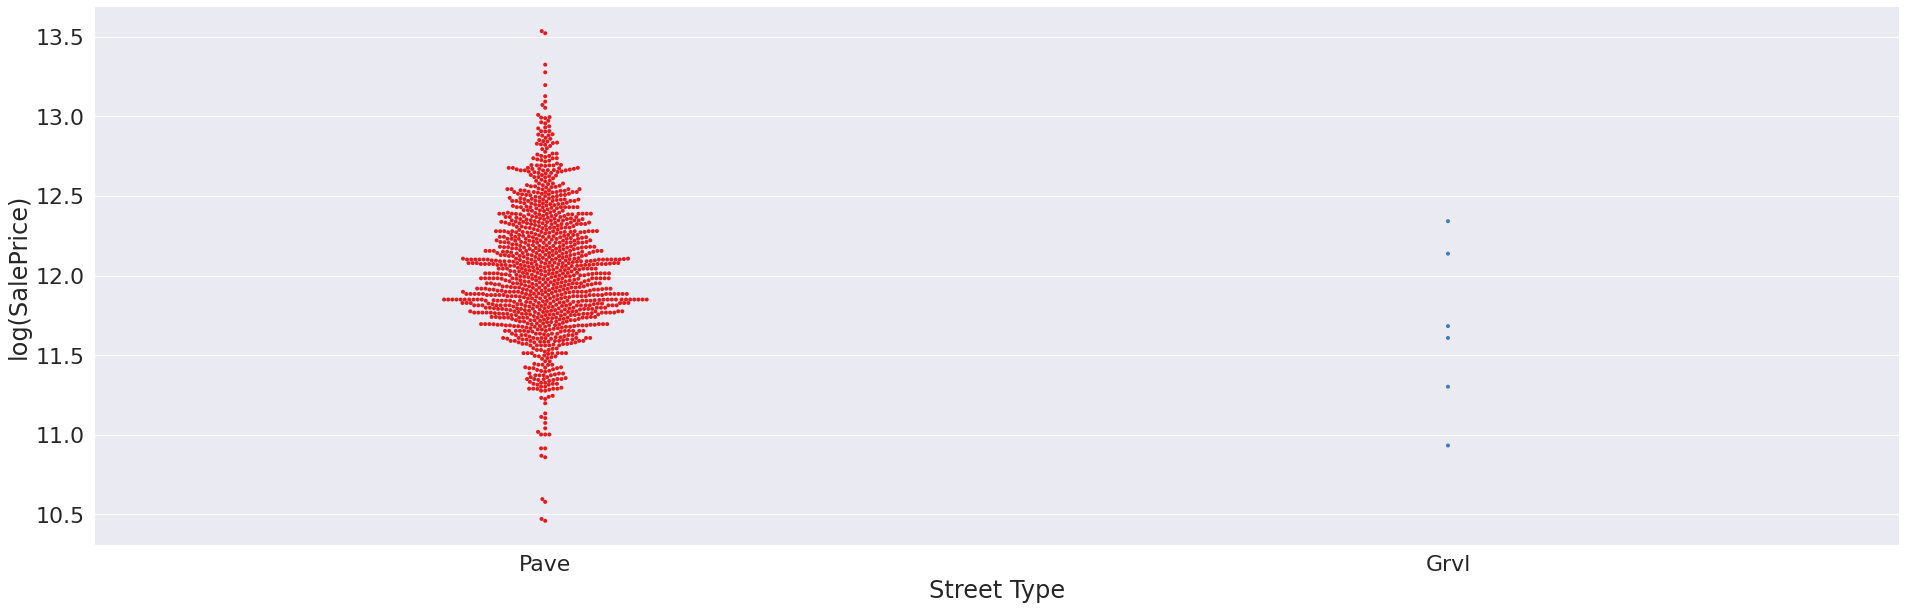

In [ ]:
sns.set(font_scale = 2)  # set font scale

# swarmplot for 'Street'
chart = sns.catplot(
    data=initBinaryDF,
    x='Street', y='logSalePrice',
    kind='swarm',
    palette='Set1',
    height=9, aspect=3,
    s=4
)
chart.set_xticklabels(rotation=0)
chart.set(xlabel='Street Type')
chart.set(ylabel='log(SalePrice)')

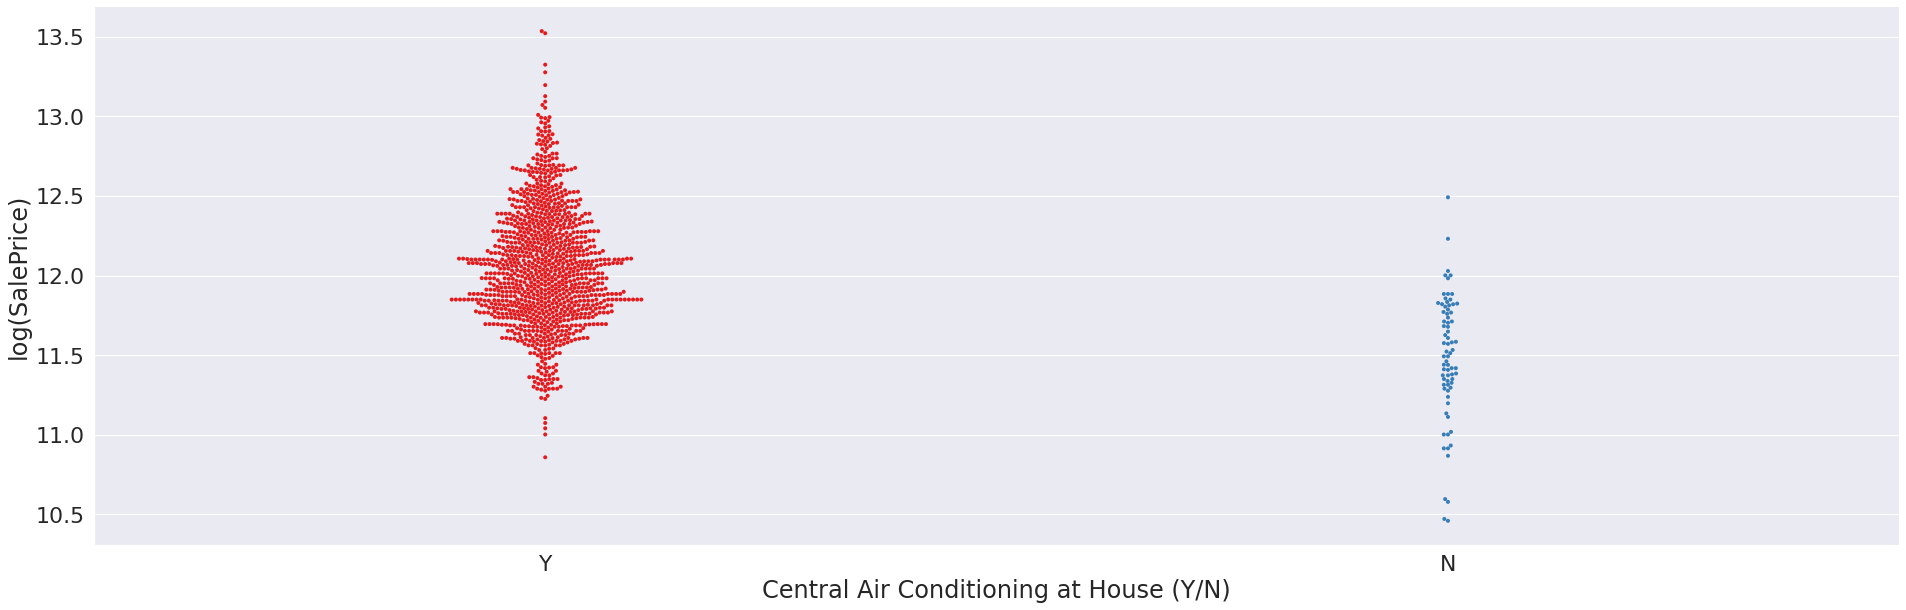

In [ ]:
# swarmplot for 'CentralAir'
chart = sns.catplot(
    data=initBinaryDF,
    x='CentralAir', y='logSalePrice',
    kind='swarm',
    palette='Set1',
    height=9, aspect=3,
    s=4
)
chart.set_xticklabels(rotation=0)
chart.set(xlabel='Central Air Conditioning at House (Y/N)')
chart.set(ylabel='log(SalePrice)')

sns.set(font_scale = 1)  # reset font scale

COMMENT:  The swarmplots show that the vast majority of houses in the Ames, Iowa region are on Paved streets (vs. Gravel).  In addition, most houses possess Central Air Conditioning.

For purposes of including a dichotomous variable in the analysis, the Central Air Conditioning variable will be included.  Note that this variable has to be converted to a (0/1) binary/indicator variable.

-----------------------------------------

### EDA Summary

In the group of continuous variables, 'TotArea' was created and selected for further evaluation, where 
'TotArea' = 'GrLivArea' + 'TotalBsmtSF'.  In addition, samples with 'TotArea' square footage > 7500 sq ft were considered to be outliers and were removed from the dataset.

In the group of discrete/intervallic variables,'YearBuilt' was selected for further evaluation.

In the group of ordinal variables, 'OverallQual' was selected for further evaluation. The existing rankings for 'OverallQual' in the dataset are integer-based and range from 1 (Very Poor) to 10 (Very Excellent).

In the group of non-ordinal, categorical variables, 'Neighborhood' was selected for further evaluation.  Due to the large number of Neighborhoods, a k-means approach was used to reduce the number of categories to either k=4 clusters or k=5 clusters.  Note that in either case, indicator variables have to be created to represent the clusters.

In the group of (two) dichotomous/binary variables, 'CentralAir' was selected for further evaluation.  Note that the (Y/N) data has to be converted to a (1/0) binary indicator variable.

# MODELING

Create dataframes for the training dataset and validation dataset. Note there will be training set and validation set dataframes for both the k=4 and k=5 'Neighborhood' clustering options.

In [ ]:
tDF_4 = trainDF_a[['TotArea','YearBuilt','OverallQual','Neighborhood','CentralAir']].copy()
tDF_4 = tDF_4[tDF_4['TotArea'] <= 7500]  # ensure high SF outliers are removed
tDF_4['TotArea2'] = tDF_4.TotArea * tDF_4.TotArea
tDF_4['Constant'] = 1
tDF_4 = tDF_4[['Constant','TotArea','TotArea2','YearBuilt','OverallQual','Neighborhood','CentralAir']]
tDF_5 = tDF_4.copy()

vDF_4 = valDF[['TotArea','YearBuilt','OverallQual','Neighborhood','CentralAir']].copy()
vDF_4 = vDF_4[vDF_4['TotArea'] <= 7500]  # remove high SF outliers
vDF_4['TotArea2'] = vDF_4.TotArea * vDF_4.TotArea
vDF_4['Constant'] = 1
vDF_4 = vDF_4[['Constant','TotArea','TotArea2','YearBuilt','OverallQual','Neighborhood','CentralAir']]
vDF_5 = vDF_4.copy()

tDF_4.head()

,Constant,TotArea,TotArea2,YearBuilt,OverallQual,Neighborhood,CentralAir
0,1,2566,6584356,2003,7,CollgCr,Y
1,1,2524,6370576,1976,6,Veenker,Y
3,1,2473,6115729,1915,7,Crawfor,Y
4,1,3343,11175649,2000,8,NoRidge,Y
5,1,2158,4656964,1993,5,Mitchel,Y


For the 'Neighborhood' variable, the validation datasets will use the k=4 and k=5 'Neighborhood'-to-'ClusterNo' mappings created using the training data.

In [ ]:
# map the cluster numbers to the names of the different Neighborhoods
tDF_4['ClusterNo'] = tDF_4['Neighborhood'].map(nbrHd_clusterNum_Dict_4)
vDF_4['ClusterNo'] = vDF_4['Neighborhood'].map(nbrHd_clusterNum_Dict_4)
tDF_5['ClusterNo'] = tDF_5['Neighborhood'].map(nbrHd_clusterNum_Dict_5)
vDF_5['ClusterNo'] = vDF_5['Neighborhood'].map(nbrHd_clusterNum_Dict_5)

# remove 'Neighborhood' variable to cleanup dataframes
tDF_4 = tDF_4.drop(columns = ['Neighborhood'])
tDF_5 = tDF_5.drop(columns = ['Neighborhood'])
vDF_4 = vDF_4.drop(columns = ['Neighborhood'])
vDF_5 = vDF_5.drop(columns = ['Neighborhood'])

Create indicator variables to represent the different cluster numbers in the dataframes.

In [ ]:
trainDummies_4 = pd.DataFrame(pd.get_dummies(data=tDF_4.ClusterNo,
                              prefix='nbrHdCluster', drop_first=True))
trainDummies_5 = pd.DataFrame(pd.get_dummies(data=tDF_5.ClusterNo,
                              prefix='nbrHdCluster', drop_first=True))
valDummies_4 = pd.DataFrame(pd.get_dummies(data=vDF_4.ClusterNo,
                              prefix='nbrHdCluster', drop_first=True))
valDummies_5 = pd.DataFrame(pd.get_dummies(data=vDF_5.ClusterNo,
                              prefix='nbrHdCluster', drop_first=True))

Add the indicator variables to the dataframes.

In [ ]:
tDF_4['NbrHd_Grp1'] = trainDummies_4.nbrHdCluster_1
tDF_4['NbrHd_Grp2'] = trainDummies_4.nbrHdCluster_2
tDF_4['NbrHd_Grp3'] = trainDummies_4.nbrHdCluster_3

tDF_5['NbrHd_Grp1'] = trainDummies_5.nbrHdCluster_1
tDF_5['NbrHd_Grp2'] = trainDummies_5.nbrHdCluster_2
tDF_5['NbrHd_Grp3'] = trainDummies_5.nbrHdCluster_3
tDF_5['NbrHd_Grp4'] = trainDummies_5.nbrHdCluster_4

vDF_4['NbrHd_Grp1'] = valDummies_4.nbrHdCluster_1
vDF_4['NbrHd_Grp2'] = valDummies_4.nbrHdCluster_2
vDF_4['NbrHd_Grp3'] = valDummies_4.nbrHdCluster_3

vDF_5['NbrHd_Grp1'] = valDummies_5.nbrHdCluster_1
vDF_5['NbrHd_Grp2'] = valDummies_5.nbrHdCluster_2
vDF_5['NbrHd_Grp3'] = valDummies_5.nbrHdCluster_3
vDF_5['NbrHd_Grp4'] = valDummies_5.nbrHdCluster_4

# remove 'ClusterNo' variable to cleanup dataframes
tDF_4 = tDF_4.drop(columns = ['ClusterNo'])
tDF_5 = tDF_5.drop(columns = ['ClusterNo'])
vDF_4 = vDF_4.drop(columns = ['ClusterNo'])
vDF_5 = vDF_5.drop(columns = ['ClusterNo'])

Convert the dichotomous/binary variable 'CentralAir' to binary and add to the dataframes.

In [ ]:
# initialize new columns
tDF_4['CentAir'] = 0
tDF_5['CentAir'] = 0
vDF_4['CentAir'] = 0
vDF_5['CentAir'] = 0

# substitute binary values for (Y/N) values
tDF_4['CentAir'] = np.where(
    tDF_4['CentralAir'] == 'N', 0, np.where(
    tDF_4['CentralAir'] == 'Y', 1, -1))
tDF_5['CentAir'] = np.where(
    tDF_5['CentralAir'] == 'N', 0, np.where(
    tDF_5['CentralAir'] == 'Y', 1, -1))
vDF_4['CentAir'] = np.where(
    vDF_4['CentralAir'] == 'N', 0, np.where(
    vDF_4['CentralAir'] == 'Y', 1, -1))
vDF_5['CentAir'] = np.where(
    vDF_5['CentralAir'] == 'N', 0, np.where(
    vDF_5['CentralAir'] == 'Y', 1, -1))

# remove 'CentralAir' variable to cleanup dataframes
tDF_4 = tDF_4.drop(columns = ['CentralAir'])
tDF_5 = tDF_5.drop(columns = ['CentralAir'])
vDF_4 = vDF_4.drop(columns = ['CentralAir'])
vDF_5 = vDF_5.drop(columns = ['CentralAir'])

**Create models using training data, and use validation set to validate models**

Perform min-max scaling on the dataframes -- note that the 'Neighborhood' cluster indicator variables and the 'CentralAir' binary variable are already min-max scaled.

In [ ]:
scaler_4 = MinMaxScaler()
tDF_4[tDF_4.columns] = scaler_4.fit_transform(tDF_4[tDF_4.columns])
vDF_4[vDF_4.columns] = scaler_4.transform(vDF_4[vDF_4.columns])

scaler_5 = MinMaxScaler()
tDF_5[tDF_5.columns] = scaler_5.fit_transform(tDF_5[tDF_5.columns])
vDF_5[vDF_5.columns] = scaler_5.transform(vDF_5[vDF_5.columns])

In [ ]:
# reset the constant column to "1"
tDF_4['Constant'] = 1
tDF_5['Constant'] = 1
vDF_4['Constant'] = 1
vDF_5['Constant'] = 1
tDF_4.head() # check

,Constant,TotArea,TotArea2,YearBuilt,OverallQual,NbrHd_Grp1,NbrHd_Grp2,NbrHd_Grp3,CentAir
0,1,0.341389,0.137389,0.949275,0.666667,1.0,0.0,0.0,1.0
1,1,0.334965,0.132852,0.753623,0.555556,1.0,0.0,0.0,1.0
3,1,0.327164,0.127442,0.311594,0.666667,1.0,0.0,0.0,1.0
4,1,0.460232,0.234842,0.927536,0.777778,0.0,1.0,0.0,1.0
5,1,0.278984,0.096479,0.876812,0.444444,0.0,0.0,1.0,1.0


**Create and evaluate models and model results using k=4 model:**

In [ ]:
model_t4 = sm.OLS(trainDF_a.logSalePrice, tDF_4).fit()
model_t4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logSalePrice   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     846.1
Date:                Mon, 11 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:29:51   Log-Likelihood:                 540.92
No. Observations:                1167   AIC:                            -1064.
Df Residuals:                    1158   BIC:                            -1018.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Constant       10.6370      0.034    313.867      0.000      10.571      10.703
TotArea         1.8767      0.174     10.774      0.000       1.535       2.218
TotArea2       -0.3401      0.203     -1.672      0.095      -0.739       0.059
YearBuilt       0.1378      0.033      4.151      0.000       0.073       0.203
OverallQual     0.7902      0.048     16.293      0.000       0.695       0.885
NbrHd_Grp1      0.1465      0.018      8.029      0.000       0.111       0.182
NbrHd_Grp2      0.2181      0.026      8.357      0.000       0.167       0.269
NbrHd_Grp3      0.0503      0.014      3.482      0.001       0.022       0.079
CentAir         0.1684      0.020      8.365      0.000       0.129       0.208
==============================================================================
Omnibus:                      211.663   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              827.059
Skew:                          -0.823   Prob(JB):                    2.55e-180
Kurtosis:                       6.781   Cond. No.                         106.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# validation dataset, prediction results
predictions_v4 = model_t4.predict(vDF_4)
predR2 = ((valDF.logSalePrice).corr(predictions_v4))**2
print('The predicted R2 for the validation set with k=4 Neighborhood clusters =', predR2)

The predicted R2 for the validation set with k=4 Neighborhood clusters = 0.8533064334368047


-------------------------------------------------

**Create and evaluate models and model results using k=5 model:**

In [ ]:
model_t5 = sm.OLS(trainDF_a.logSalePrice, tDF_5).fit()
model_t5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logSalePrice   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     775.2
Date:                Mon, 11 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:30:21   Log-Likelihood:                 556.43
No. Observations:                1167   AIC:                            -1093.
Df Residuals:                    1157   BIC:                            -1042.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Constant       10.4905      0.047    222.047      0.000      10.398      10.583
TotArea         1.7510      0.173     10.097      0.000       1.411       2.091
TotArea2       -0.2206      0.202     -1.092      0.275      -0.617       0.176
YearBuilt       0.1612      0.033      4.836      0.000       0.096       0.227
OverallQual     0.7946      0.048     16.566      0.000       0.701       0.889
NbrHd_Grp1      0.3613      0.038      9.475      0.000       0.286       0.436
NbrHd_Grp2      0.2044      0.033      6.161      0.000       0.139       0.270
NbrHd_Grp3      0.2905      0.034      8.588      0.000       0.224       0.357
NbrHd_Grp4      0.1572      0.034      4.574      0.000       0.090       0.225
CentAir         0.1749      0.020      8.768      0.000       0.136       0.214
==============================================================================
Omnibus:                      224.502   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              966.483
Skew:                          -0.845   Prob(JB):                    1.35e-210
Kurtosis:                       7.125   Cond. No.                         107.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# validation dataset, prediction results
predictions_v5 = model_t5.predict(vDF_5)
predR2 = ((valDF.logSalePrice).corr(predictions_v5))**2
print('The predicted R2 for the validation set with k=5 Neighborhood clusters =', predR2)

The predicted R2 for the validation set with k=5 Neighborhood clusters = 0.8575201108412193


**Summary of Regression Model Results for Training set and Validation set:**

k=4 Neighborhood Clusters in Model; Training data:   R2=0.854

k=4 Neighborhood Clusters in Model; Validation data: R2=0.853

k=5 Neighborhood Clusters in Model; Training data:  R2=0.858

k=5 Neighborhood Clusters in Model; Validation data:  R2=0.8575


### SUMMARY OF VALIDATION TEST RESULTS

Cross-validation test results (R2) indicate the regression model possessing five k-means clusters slightly outperformed the model possessing four k-means clusters, where the clusters represented groups of Neighborhoods possessing similar log(SalePrice) statistics.  Furthermore, the R2 results using the previously-unseen validation dataset were very close to the R2 results using the training dataset -- this suggests the models possess good generalization characteristics when predicting Sales Prices for new, previously-unseen data.

In addition to the Neighborhood-related clusters, other predictor variables included 'TotArea', which was the sum of original variables 'GrLivArea' and 'TotalBsmtSF', its quadratic version 'TotArea2', 'YearBuilt', 'OverallQual', and the dichotomous variable 'CentralAir'. These variables were Min-Max scaled prior to being used to create the models.

# TESTING WITH KAGGLE.COM test.csv DATASET

In [ ]:
# remove any residual data from previous runs
!rm test.csv
!rm test\ \(1\).csv

In [ ]:
# upload the Kaggle.com test dataset
from google.colab import files
upload = files.upload()

Saving test.csv to test.csv


In [ ]:
# read in test data
origTestDF = pd.read_csv('test.csv')

In [ ]:
# create new variables
origTestDF['TotArea'] = origTestDF.GrLivArea + origTestDF.TotalBsmtSF
origTestDF['TotArea2'] = origTestDF.TotArea * origTestDF.TotArea
origTestDF['Constant'] = 1

In [ ]:
# create new dataframe with variables associated with the model
testDF = origTestDF[['Id','Constant','TotArea','TotArea2','YearBuilt','OverallQual','Neighborhood','CentralAir']]
testDF.head()

,Id,Constant,TotArea,TotArea2,YearBuilt,OverallQual,Neighborhood,CentralAir
0,1461,1,1778.0,3161284.0,1961,5,NAmes,Y
1,1462,1,2658.0,7064964.0,1958,6,NAmes,Y
2,1463,1,2557.0,6538249.0,1997,5,Gilbert,Y
3,1464,1,2530.0,6400900.0,1998,6,Gilbert,Y
4,1465,1,2560.0,6553600.0,1992,8,StoneBr,Y


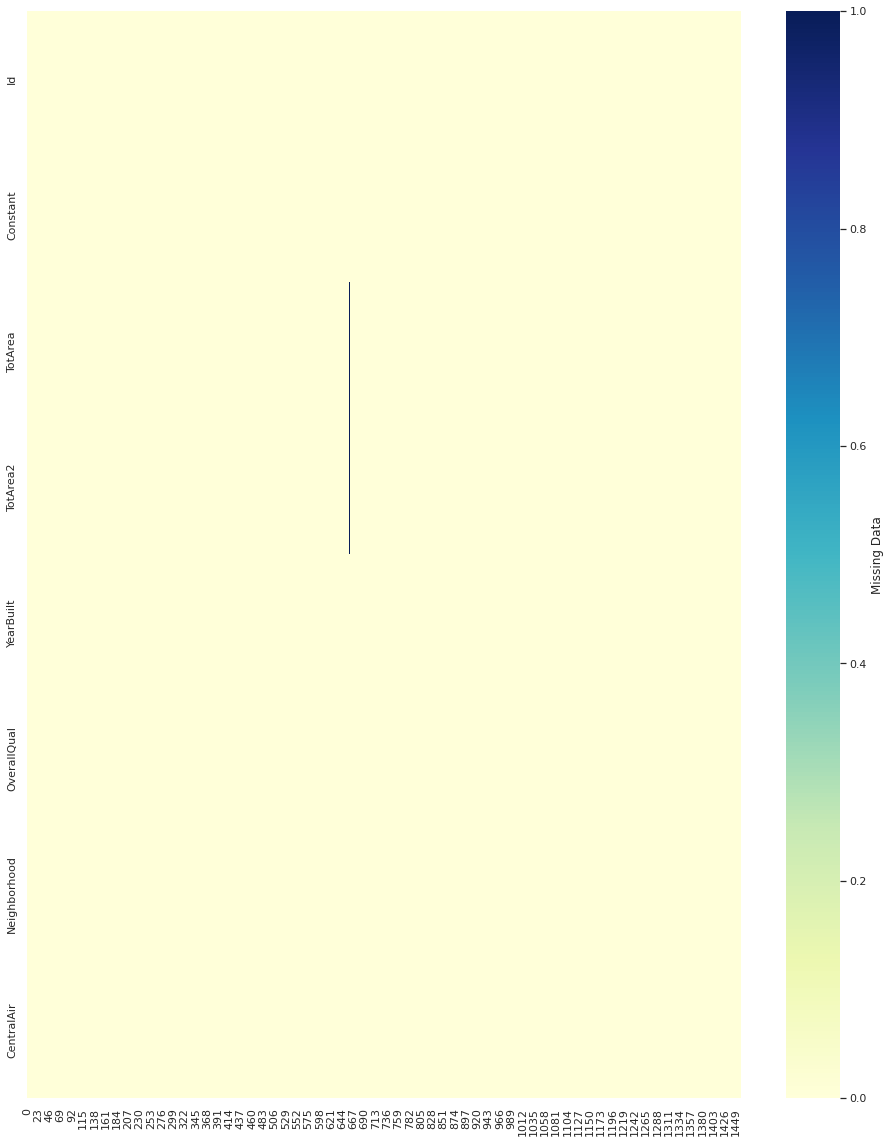

In [ ]:
# visually check to see if any of these columns possess missing data usng heatmap
plt.figure(figsize=(16,20))
sns.heatmap(testDF.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [ ]:
# check again using printout
pd.set_option('display.max_rows', None)  # display all the results
testDF.isnull().sum()

Id              0
Constant        0
TotArea         1
TotArea2        1
YearBuilt       0
OverallQual     0
Neighborhood    0
CentralAir      0
dtype: int64

In [ ]:
# impute missing values ('TotArea','TotArea2') with median values
testDF = testDF.fillna(testDF.median())

# check for missing values again after imputation
pd.set_option('display.max_rows', None)  # display all the results
testDF.isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


Id              0
Constant        0
TotArea         0
TotArea2        0
YearBuilt       0
OverallQual     0
Neighborhood    0
CentralAir      0
dtype: int64

In [ ]:
# map the cluster numbers to the names of the different Neighborhoods (k=5 clusters)
testDF['ClusterNo'] = testDF['Neighborhood'].map(nbrHd_clusterNum_Dict_5)

# remove 'Neighborhood' variable to cleanup dataframe
testDF = testDF.drop(columns = ['Neighborhood'])

In [ ]:
# inspect dataframe
testDF.head()

,Id,Constant,TotArea,TotArea2,YearBuilt,OverallQual,CentralAir,ClusterNo
0,1461,1,1778.0,3161284.0,1961,5,Y,2
1,1462,1,2658.0,7064964.0,1958,6,Y,2
2,1463,1,2557.0,6538249.0,1997,5,Y,3
3,1464,1,2530.0,6400900.0,1998,6,Y,3
4,1465,1,2560.0,6553600.0,1992,8,Y,1


In [ ]:
# check for missing values again after mapping
pd.set_option('display.max_rows', None)  # display all the results
testDF.isnull().sum()

Id             0
Constant       0
TotArea        0
TotArea2       0
YearBuilt      0
OverallQual    0
CentralAir     0
ClusterNo      0
dtype: int64

In [ ]:
# create indicator dummy variables
testDummies = pd.DataFrame(pd.get_dummies(data=testDF.ClusterNo,
                              prefix='nbrHdCluster', drop_first=True))

In [ ]:
# add dummy indicator variable to the test dataframe
testDF['NbrHd_Grp1'] = testDummies.nbrHdCluster_1
testDF['NbrHd_Grp2'] = testDummies.nbrHdCluster_2
testDF['NbrHd_Grp3'] = testDummies.nbrHdCluster_3
testDF['NbrHd_Grp4'] = testDummies.nbrHdCluster_4

# remove 'ClusterNo' variable to cleanup dataframe
testDF = testDF.drop(columns = ['ClusterNo'])

In [ ]:
# convert the dichotomous/binary variable to binary
testDF['CentAir'] = 0  # initialize

# substitute binary values for (Y/N) values
testDF['CentAir'] = np.where(
    testDF['CentralAir'] == 'N', 0, np.where(
    testDF['CentralAir'] == 'Y', 1, -1))

# remove 'CentralAir' variable to cleanup dataframe
testDF = testDF.drop(columns = ['CentralAir'])
testDF.head()

,Id,Constant,TotArea,TotArea2,YearBuilt,OverallQual,NbrHd_Grp1,NbrHd_Grp2,NbrHd_Grp3,NbrHd_Grp4,CentAir
0,1461,1,1778.0,3161284.0,1961,5,0,1,0,0,1
1,1462,1,2658.0,7064964.0,1958,6,0,1,0,0,1
2,1463,1,2557.0,6538249.0,1997,5,0,0,1,0,1
3,1464,1,2530.0,6400900.0,1998,6,0,0,1,0,1
4,1465,1,2560.0,6553600.0,1992,8,1,0,0,0,1


In [ ]:
# create a dataframe that matches the columns in the Min-Max scaled training dataset
tempDF = testDF[['Constant','TotArea','TotArea2','YearBuilt','OverallQual','NbrHd_Grp1','NbrHd_Grp2','NbrHd_Grp3','NbrHd_Grp4','CentAir']]

# perform Min-Max scaling using the training set scaler
tempDF[tempDF.columns] = scaler_5.transform(tempDF[tempDF.columns])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
# reset the constant column to "1"
tempDF['Constant'] = 1
tempDF.head() # check

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Constant,TotArea,TotArea2,YearBuilt,OverallQual,NbrHd_Grp1,NbrHd_Grp2,NbrHd_Grp3,NbrHd_Grp4,CentAir
0,1,0.220863,0.064732,0.644928,0.444444,0.0,1.0,0.0,0.0,1.0
1,1,0.355460,0.147591,0.623188,0.555556,0.0,1.0,0.0,0.0,1.0
2,1,0.340012,0.136411,0.905797,0.444444,0.0,0.0,1.0,0.0,1.0
3,1,0.335883,0.133495,0.913043,0.555556,0.0,0.0,1.0,0.0,1.0
4,1,0.340471,0.136737,0.869565,0.777778,1.0,0.0,0.0,0.0,1.0


In [ ]:
# put the Min-Max-scaled tempDF columns back into the testDF dataframe
testDF['Constant'] = 1
testDF['TotArea'] = tempDF.TotArea
testDF['TotArea2'] = tempDF.TotArea2
testDF['YearBuilt'] = tempDF.YearBuilt
testDF['OverallQual'] = tempDF.OverallQual
testDF['NbrHd_Grp1'] = tempDF.NbrHd_Grp1
testDF['NbrHd_Grp2'] = tempDF.NbrHd_Grp2
testDF['NbrHd_Grp3'] = tempDF.NbrHd_Grp3
testDF['NbrHd_Grp4'] = tempDF.NbrHd_Grp4
testDF['CentAir'] = tempDF.CentAir
testDF.head(25)

,Id,Constant,TotArea,TotArea2,YearBuilt,OverallQual,NbrHd_Grp1,NbrHd_Grp2,NbrHd_Grp3,NbrHd_Grp4,CentAir
0,1461,1,0.220863,0.064732,0.644928,0.444444,0.0,1.0,0.0,0.0,1.0
1,1462,1,0.355460,0.147591,0.623188,0.555556,0.0,1.0,0.0,0.0,1.0
2,1463,1,0.340012,0.136411,0.905797,0.444444,0.0,0.0,1.0,0.0,1.0
3,1464,1,0.335883,0.133495,0.913043,0.555556,0.0,0.0,1.0,0.0,1.0
4,1465,1,0.340471,0.136737,0.869565,0.777778,1.0,0.0,0.0,0.0,1.0
5,1466,1,0.318752,0.121733,0.876812,0.555556,0.0,0.0,1.0,0.0,1.0
6,1467,1,0.309116,0.115350,0.869565,0.555556,0.0,0.0,1.0,0.0,1.0
7,1468,1,0.293668,0.105469,0.913043,0.555556,0.0,0.0,1.0,0.0,1.0
8,1469,1,0.352860,0.145678,0.855072,0.666667,0.0,0.0,1.0,0.0,1.0
9,1470,1,0.218721,0.063680,0.710145,0.333333,0.0,1.0,0.0,0.0,1.0


In [ ]:
# calc predicted logSalePrice results from the Kaggle test dataset
testDF['predLogSalePrice'] = (model_t5.predict(tempDF).array).astype(float)
testDF['SalePrice'] = np.exp(testDF.predLogSalePrice)
testDF.head(10)

,Id,Constant,TotArea,TotArea2,YearBuilt,OverallQual,NbrHd_Grp1,NbrHd_Grp2,NbrHd_Grp3,NbrHd_Grp4,CentAir,predLogSalePrice,SalePrice
0,1461,1,0.220863,0.064732,0.644928,0.444444,0.0,1.0,0.0,0.0,1.0,11.699388,120498.000430
1,1462,1,0.355460,0.147591,0.623188,0.555556,0.0,1.0,0.0,0.0,1.0,12.001584,163012.857721
2,1463,1,0.340012,0.136411,0.905797,0.444444,0.0,0.0,1.0,0.0,1.0,12.020369,166103.966562
3,1464,1,0.335883,0.133495,0.913043,0.555556,0.0,0.0,1.0,0.0,1.0,12.103240,180455.659846
4,1465,1,0.340471,0.136737,0.869565,0.777778,1.0,0.0,0.0,0.0,1.0,12.350902,231168.489898
5,1466,1,0.318752,0.121733,0.876812,0.555556,0.0,0.0,1.0,0.0,1.0,12.069997,174555.245355
6,1467,1,0.309116,0.115350,0.869565,0.555556,0.0,0.0,1.0,0.0,1.0,12.053363,171675.783160
7,1468,1,0.293668,0.105469,0.913043,0.555556,0.0,0.0,1.0,0.0,1.0,12.035502,168636.761633
8,1469,1,0.352860,0.145678,0.855072,0.666667,0.0,0.0,1.0,0.0,1.0,12.209226,200631.618445
9,1470,1,0.218721,0.063680,0.710145,0.333333,0.0,1.0,0.0,0.0,1.0,11.618095,111089.938648


In [ ]:
# create dataframe for Kaggle submission
KaggleDF = testDF[['Id','SalePrice']].copy()
KaggleDF.head()

,Id,SalePrice
0,1461,120498.000430
1,1462,163012.857721
2,1463,166103.966562
3,1464,180455.659846
4,1465,231168.489898


In [ ]:
# save as csv file (see Colab files folder)
KaggleDF.to_csv('Huff_Ames.csv', index=False)

Git repository is at https://github.com/DanDeeDan/MSDS422_Assignment2.git

#### Test Results

My Kaggle.com test results score was 0.16441.

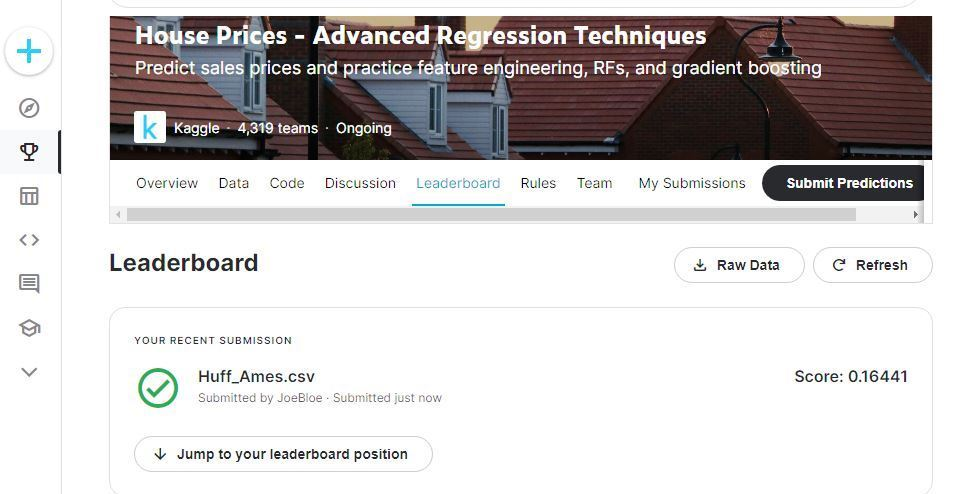

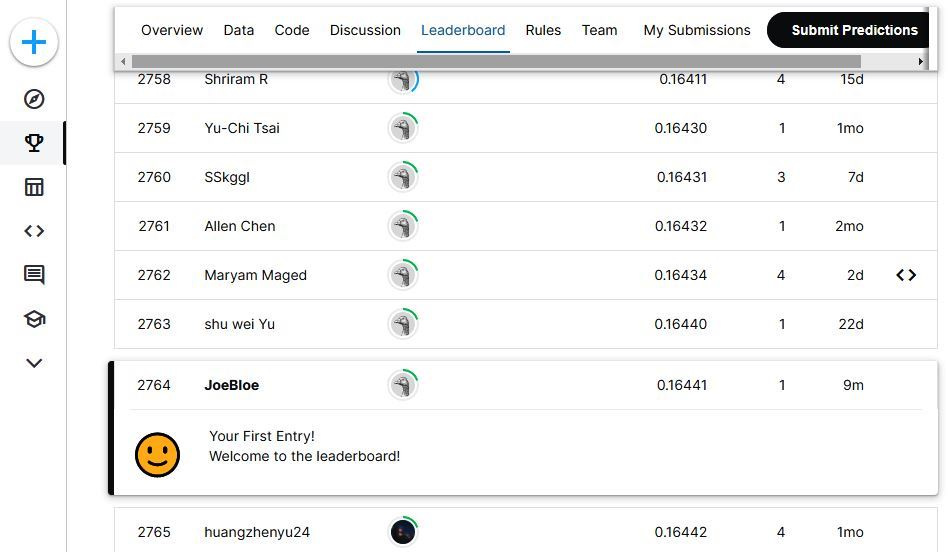

# ASSIGNMENT SUMMARY

In this exercise, a large dataset, consisting of approximately 80 variables and 1460 runs, was analyzed and then used to create a linear regression model for predicting Sales Prices of houses in the Ames, Iowa region.

Various evaluations, manipulations and transformations were performed on the variables to improve their potential usefulness in a regression model. After examining plots of the original, housing 'SalePrice' response variable, this variable was log-transformed to produce a response variable with better Normality characteristics. The other variables in the dataset were considered as potential predictor variables. Initially, these variables were separated according to their variable type (i.e., continuous, intervallic, ordinal, non-ordinal-categorical and dichotomous/binary), and each group was evaluated to find the most promising predictors in each group (based largely upon the level of correlation with the response variable). Several new variables were obtained by combining original variables, and one of these new variables, 'TotArea', as well as its quadratic version ('TotArea2'), were eventually used in the final regression model. Common transformations, such as Min-Max scaling, were used to normalize predictor magnitudes.  A k-means, clustering approach was used to group similar categories of the 'Neighborhood' categorical variable to reduce the number of different categories and simplify this predictor.

The predictors that were eventually included in the model are not surprising.   
'Neighborhood' addresses the "Location, Location, Location" aspect commonly associated with real estate valuation,  'TotArea' corresponds with the size of the house, 'YearBuilt' corresponds with the "newness" of the house, and 'OverallCond' corresponds with the general condition of the house.  After The dichotomous, (Y/N) variable 'CentralAir' was converted to (1/0) binary, this variable was also included in the model.  Although this variable was largely included so that the model would possess a dichotomous variable, houses that lack Central Air Conditioning tended to be associated with lower=priced houses.

Creating a linear regression model from a large dataset was challenging, and many interesting techniques were explored within this assignment.  It is likely further improvements could be made to the model.  However, we will continue to look at this dataset in coming weeks and in future assignments, so further opportunities will be available to improve the current model.